## Import Necessary Libraries

In [1]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import pygad
import numpy
import glob
import wntr
import os

In [2]:
plt.rcParams['figure.figsize'] = (12,8)

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# wipe all solutions in the directory
all_solutions = glob.glob('../temp/FITNESS_SOLUTION_*')
all_generations = glob.glob('../temp/GENERATION_*')
# for i in all_solutions:
#     os.remove(i)
# for j in all_generations:
#     os.remove(j)


# Uncomment and run the above code if you want to re-optimze this project otherwise, go ahead.
# Recommendation: Uncomment and run the code if you want re-optimize.

## Read Inp File

In [5]:
class Config:
    num_generations =100 #Number of generations.
    num_parents_mating = 1 # Number of solutions to be selected as parents in the mating pool.
    sol_per_pop = 20 # Number of solutions in the population.
    num_genes = 1 #len(function_inputs) --> this can be an array
    init_range_low = 0
    init_range_high = 1
    parent_selection_type = "sss" # Type of parent selection.
    keep_parents = -1 # Number of parents to keep in the next population. -1 means keep all parents and 0 means keep nothing.
    crossover_type = "single_point" # Type of the crossover operator. 
    mutation_type = "random" # Type of the mutation operator.
    mutation_num_genes=1 # Type of the mutation operator.
    last_fitness = 0
    
    inp_file_path = r"../data/Real_Synthetic_Net.inp" 
    function_inputs = None
    desired_output = None

In [51]:
class WaterLeakModel(Config):
    
    def __init__(self, node:str):
        ''' 
            node: node/junction ID in the network
        '''
        
        # Check if node is junction_name 
        wn = wntr.network.WaterNetworkModel(self.inp_file_path)
        assert wn.junction_name_list.count(node) == 1, "Node not found in the network"
        self.node_index = wn.junction_name_list.index(node)
        
        self.node = node
        
        #Setup all neccessary folders we need to work with, i.e. create them if they don't exist
        if not os.path.exists('../temp/solutions_for_'+self.node):
            os.mkdir('../temp/solutions_for_'+self.node)
            
        if not os.path.exists('../plots/plots_for_'+self.node):
            os.mkdir('../plots/plots_for_'+self.node)


        if not os.path.exists('results/results_for_'+self.node):
            os.mkdir('results/results_for_'+self.node)
            
        self.temp_dir = '../temp/solutions_for_'+self.node
        self.plots_dir = '..plots/plots_for_'+self.node
        
    
    def simulate(self, wn, plot_graph=True):
        """
        If plot_graph is set to true, a graph of the network is plotted after simulation
        """
        # Plot pressure after add leak to node
            
        sim = wntr.sim.WNTRSimulator(wn)
        results = sim.run_sim()
        pressure = results.node['pressure']
        pressure_at_N6 = pressure.loc[:,wn.junction_name_list[self.node_index]]
        if plot_graph:
            wntr.graphics.plot_network(wn, node_attribute=pressure.any(), node_size=150, title='Pressure at 0 hours')
        
        return results
    
    def change_discharge_coefficient(self, wn, emitter_value):
        """
        This function changes the emitter coefficient for selected node in the network, and create a 
        structured representation of our data, a csv.
        
        parameters
        ----------
        wn: wntr network object
        emitter_value: the emitter coefficient value
        """
        
        # Change emitter coefficient
        node = wn.get_node(str(self.node))
        node.add_leak(wn, area=0.00015, start_time=0, end_time=1, discharge_coeff=emitter_value)
        return self.simulate(wn, plot_graph=False)
    
    def export_results(self, solutions:list, path:str, name:str):
        """
        Concatenates all solutions generated and exports as a single csv file
        
        parameters
        ----------
        solution: a list of all paths to the solutions csv files
        path: path where concatenated solution will be exported to
        name: name to be assigned to exported file
        """
        if not os.path.exists(path):
            os.mkdir(path)
        
        temp = pd.DataFrame()
        for i in range(len(solutions)):
            data = pd.read_csv(solutions[i])
            if i == 0:
                temp = data
            else:
                temp = pd.concat([temp, data])
        name+=".csv"
        try:
            temp.to_csv(os.path.join(path,name),index=False)
            print(f'File Exported Successfully to path: {os.path.join(path, name)}')
        except Exception as e:
            print(e)
            
    def run(self, leak_area=0.00015, start_time=0, end_time=1, discharge_coeff=.5, function_inputs=0.5, plot_graph=True):
        """
        Adds a leak to node passed to WaterLeakModel() object and simulates
        
        parameters
        ----------
        leak_area: area of the leak
        start_time: time in seconds to start the leak
        end_time: time in seconds to end the leak
        discharge_coeff: Leak discharge coefficient; Takes on values between 0 and 1.
        function_inputs = inputs for optimization, can be array of numbers
        plot_graph: If plot_graph is set to true, a graph of the network is plotted after simulation
        """
        
        # Add leak and simulate
        wn = wntr.network.WaterNetworkModel(self.inp_file_path)
        node = wn.get_node(self.node)
        node.add_leak(wn, area=leak_area, start_time=start_time, end_time=end_time, discharge_coeff=.5)
        self.simulate(wn, plot_graph=plot_graph)

        self.function_inputs = function_inputs
        self.desired_output = node.head - node.elevation
        

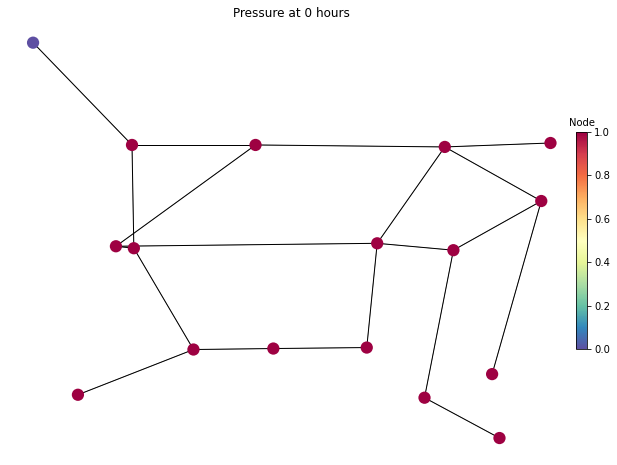

In [52]:
# Instantiate the pygad optimization class
water_model = WaterLeakModel(node='N6')
water_model.run()

In [53]:
water_model.desired_output

26.540357400761586

In [54]:
def fitness_function(solution, solution_idx):
        
    wn = wntr.network.WaterNetworkModel(water_model.inp_file_path)
    results = water_model.change_discharge_coefficient(wn, emitter_value=abs(solution[0])) #change emitter coefficient

    pressure = results.node['pressure']
    pressure_output = pressure.loc[:,water_model.node]
    
    demands=results.node['demand']
    demand_output = demands.loc[:,water_model.node]

    fitness = 1.0 / (np.abs(pressure_output - water_model.desired_output) + 0.000001)

    # Structure and export the output of the fitness
    data = pd.DataFrame(columns=['EMITTER_COEFFICIENT_SOLUTION','PRESSURE_OUTPUT','OUTPUT_DEMAND','FITNESS'])
    data = data.append({'EMITTER_COEFFICIENT_SOLUTION':abs(solution[0]),'PRESSURE_OUTPUT':list(pressure_output)[0],'FITNESS':list(fitness)[0],'OUTPUT_DEMAND':(list(demand_output) [0]*1000)},ignore_index=True)
    data.to_csv(f"{water_model.temp_dir}/FITNESS_SOLUTION_{str(abs(solution[0]))}.csv",index=False) 

    print('=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========')
    print ('======|', abs(round(solution[0],3)),'|===========|',list(round(pressure_output,3))[0],'|==================|',list(round(fitness, 3))[0],'|==========')
    print('================================='*2)

    return list(fitness)[0]

In [55]:
#################### Create a Callback Function ########################
last_fitness = 0
def callback_generation(ga_instance): # This function prints algorithm progress
    global last_fitness
    print("Generation = {generation}".format(generation=ga_instance.generations_completed)) 
    print("Fitness = {fitness}".format(fitness=ga_instance.best_solution()[1]))
    print("Change = {change}".format(change=ga_instance.best_solution()[1] - last_fitness)) 

    data =pd.DataFrame(columns=['GENERATION','FITNESS'])
    data =data.append({'GENERATION':ga_instance.generations_completed,'FITNESS': ga_instance.best_solution ()[1]},ignore_index=True)
    data.to_csv(f"{water_model.temp_dir}/GENERATION_{str(ga_instance.generations_completed)}.csv",index=False) 
    last_fitness = ga_instance.best_solution()[1]

In [44]:
# Instantiate the pygad optimization class
ga_instance = pygad.GA(num_generations=water_model.num_generations,
                       num_parents_mating=water_model.num_parents_mating, 
                       fitness_func=fitness_function, 
                       sol_per_pop=water_model.sol_per_pop,
                       num_genes=water_model.num_genes,
                       init_range_low=water_model.init_range_low,
                       init_range_high=water_model.init_range_high,
                       parent_selection_type=water_model.parent_selection_type,
                       keep_parents=water_model.keep_parents,
                       crossover_type=water_model.crossover_type,
                       mutation_type=water_model.mutation_type,
                       mutation_num_genes=water_model.mutation_num_genes,
                       callback_generation=callback_generation)

In [12]:
ga_instance.run()

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.865 |===========| 26.482 |==================| 17.27 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.34 |===========| 26.565 |==================| 39.954 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.828 |===========| 26.488 |==================| 19.208 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.447 |===========| 26.549 |==================| 120.444 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.267 |===========| 26.577 |==================| 27.472 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.83 |===========| 26.488 |==================| 19.117 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.689 |===========| 26.511 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.653 |===========| 26.516 |==================| 41.3 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.037 |===========| 26.455 |==================| 11.686 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.723 |===========| 26.505 |==================| 28.292 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.266 |===========| 26.577 |==================| 27.403 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.184 |===========| 26.59 |==================| 20.307 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.166 |===========| 26.592 |==================| 19.21 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.88 |===========| 26.48 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.723 |===========| 26.505 |==================| 28.292 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.266 |===========| 26.577 |==================| 27.403 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.184 |===========| 26.59 |==================| 20.307 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.166 |===========| 26.592 |==================| 19.21 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.88 |===========| 26.48 |==================| 16.574 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.237 |===========| 26.422 |==================| 8.473 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.232 |===========| 26.582 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.286 |===========| 26.414 |==================| 7.934 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.78 |===========| 26.496 |==================| 22.572 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.286 |===========| 26.574 |==================| 29.931 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.966 |===========| 26.466 |==================| 13.49 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.507 |===========| 26.539 |==================| 847.177 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.888 |===========| 26.479 |==================| 16.233 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.089 |===========| 26.446 |============

======| 0.78 |===========| 26.496 |==================| 22.572 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.286 |===========| 26.574 |==================| 29.931 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.966 |===========| 26.466 |==================| 13.49 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.507 |===========| 26.539 |==================| 847.177 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.888 |===========| 26.479 |==================| 16.233 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.089 |===========| 26.446 |==================| 10.634 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.928 |===========| 26.472 |==================| 14.68 |==========
=====|SOLUTION|===========|OUTPUT|===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.286 |===========| 26.574 |==================| 29.931 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.966 |===========| 26.466 |==================| 13.49 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.507 |===========| 26.539 |==================| 847.177 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.888 |===========| 26.479 |==================| 16.233 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.089 |===========| 26.446 |==================| 10.634 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.928 |===========| 26.472 |==================| 14.68 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.851 |===========| 26.485 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.124 |===========| 26.441 |==================| 10.036 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.156 |===========| 26.594 |==================| 18.683 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.349 |===========| 26.564 |==================| 42.359 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.206 |===========| 26.586 |==================| 21.788 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.164 |===========| 26.593 |==================| 19.089 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.121 |===========| 26.599 |==================| 16.95 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.312 |===========| 26.57 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.156 |===========| 26.594 |==================| 18.683 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.349 |===========| 26.564 |==================| 42.359 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.206 |===========| 26.586 |==================| 21.788 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.164 |===========| 26.593 |==================| 19.089 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.121 |===========| 26.599 |==================| 16.95 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.312 |===========| 26.57 |==================| 33.967 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.312 |===========| 26.41 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.713 |===========| 26.507 |==================| 29.715 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.557 |===========| 26.531 |==================| 111.319 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.181 |===========| 26.431 |==================| 9.174 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.342 |===========| 26.405 |==================| 7.397 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.343 |===========| 26.565 |==================| 40.557 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.775 |===========| 26.497 |==================| 22.931 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.171 |===========| 26.592 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.342 |===========| 26.405 |==================| 7.397 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.343 |===========| 26.565 |==================| 40.557 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.775 |===========| 26.497 |==================| 22.931 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.171 |===========| 26.592 |==================| 19.496 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.263 |===========| 26.577 |==================| 26.952 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.235 |===========| 26.423 |==================| 8.492 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.909 |===========| 26.475 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.343 |===========| 26.565 |==================| 40.557 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.775 |===========| 26.497 |==================| 22.931 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.171 |===========| 26.592 |==================| 19.496 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.263 |===========| 26.577 |==================| 26.952 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.482 |===========| 26.543 |==================| 348.596 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.309 |===========| 26.411 |==================| 7.702 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.753 |===========| 26.5 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.482 |===========| 26.543 |==================| 348.596 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.309 |===========| 26.411 |==================| 7.702 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.753 |===========| 26.5 |==================| 25.019 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.182 |===========| 26.59 |==================| 20.178 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.901 |===========| 26.477 |==================| 15.706 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.28 |===========| 26.575 |==================| 29.067 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.303 |===========| 26.571 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.182 |===========| 26.59 |==================| 20.178 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.901 |===========| 26.477 |==================| 15.706 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.28 |===========| 26.575 |==================| 29.067 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.303 |===========| 26.571 |==================| 32.527 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.233 |===========| 26.582 |==================| 23.997 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.181 |===========| 26.59 |==================| 20.121 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.213 |===========| 26.585 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.026 |===========| 26.456 |==================| 11.922 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.644 |===========| 26.518 |==================| 44.042 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.387 |===========| 26.398 |==================| 7.012 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.379 |===========| 26.559 |==================| 52.826 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.397 |===========| 26.557 |==================| 61.733 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.014 |===========| 26.616 |==================| 13.267 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.419 |===========| 26.553 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.644 |===========| 26.518 |==================| 44.042 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.387 |===========| 26.398 |==================| 7.012 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.379 |===========| 26.559 |==================| 52.826 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.397 |===========| 26.557 |==================| 61.733 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.014 |===========| 26.616 |==================| 13.267 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.419 |===========| 26.553 |==================| 78.487 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.325 |===========| 26.568 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.115 |===========| 26.6 |==================| 16.681 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.23 |===========| 26.582 |==================| 23.741 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.371 |===========| 26.561 |==================| 49.46 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.754 |===========| 26.5 |==================| 24.915 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.086 |===========| 26.605 |==================| 15.533 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.485 |===========| 26.543 |==================| 415.026 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.116 |===========| 26.6 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.754 |===========| 26.5 |==================| 24.915 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.086 |===========| 26.605 |==================| 15.533 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.485 |===========| 26.543 |==================| 415.026 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.116 |===========| 26.6 |==================| 16.742 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.861 |===========| 26.483 |==================| 17.429 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.833 |===========| 26.488 |==================| 18.959 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.305 |===========| 26.571 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.485 |===========| 26.543 |==================| 415.026 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.116 |===========| 26.6 |==================| 16.742 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.861 |===========| 26.483 |==================| 17.429 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.833 |===========| 26.488 |==================| 18.959 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.305 |===========| 26.571 |==================| 32.711 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.075 |===========| 26.606 |==================| 15.128 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.144 |===========| 26.596 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.606 |===========| 26.524 |==================| 59.648 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.157 |===========| 26.435 |==================| 9.516 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.207 |===========| 26.586 |==================| 21.86 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.391 |===========| 26.558 |==================| 58.305 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.339 |===========| 26.566 |==================| 39.606 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.09 |===========| 26.604 |==================| 15.691 |==========
Fitness = 847.1766019599985
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.57 |=======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.157 |===========| 26.435 |==================| 9.516 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.207 |===========| 26.586 |==================| 21.86 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.391 |===========| 26.558 |==================| 58.305 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.339 |===========| 26.566 |==================| 39.606 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.09 |===========| 26.604 |==================| 15.691 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.57 |===========| 26.529 |==================| 90.516 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.391 |===========| 26.397 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.274 |===========| 26.576 |==================| 28.285 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.527 |===========| 26.536 |==================| 238.189 |==========
Generation = 9
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.452 |===========| 26.548 |==================| 132.026 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.106 |===========| 26.602 |==================| 16.293 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.371 |===========| 26.561 |==================| 49.588 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.49 |===========| 26.542 |==================| 664.924 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.835 |===========| 2

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.527 |===========| 26.536 |==================| 238.189 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.452 |===========| 26.548 |==================| 132.026 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.106 |===========| 26.602 |==================| 16.293 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.371 |===========| 26.561 |==================| 49.588 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.49 |===========| 26.542 |==================| 664.924 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.835 |===========| 26.487 |==================| 18.813 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.919 |===========| 26.

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.344 |===========| 26.565 |==================| 40.877 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.088 |===========| 26.604 |==================| 15.599 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.228 |===========| 26.583 |==================| 23.534 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.101 |===========| 26.602 |==================| 16.12 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.332 |===========| 26.567 |==================| 38.016 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.007 |===========| 26.46 |==================| 12.383 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.408 |===========| 26.394 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.332 |===========| 26.567 |==================| 38.016 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.007 |===========| 26.46 |==================| 12.383 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.408 |===========| 26.394 |==================| 6.844 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.799 |===========| 26.493 |==================| 21.096 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.121 |===========| 26.599 |==================| 16.952 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.939 |===========| 26.471 |==================| 14.34 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.0 |===========| 26.461 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.121 |===========| 26.599 |==================| 16.952 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.939 |===========| 26.471 |==================| 14.34 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.0 |===========| 26.461 |==================| 12.557 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.232 |===========| 26.423 |==================| 8.525 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.153 |===========| 26.594 |==================| 18.519 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.064 |===========| 26.45 |==================| 11.123 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.205 |===========| 26.586 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.427 |===========| 26.391 |==================| 6.701 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.322 |===========| 26.568 |==================| 35.876 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.944 |===========| 26.47 |==================| 14.154 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.167 |===========| 26.592 |==================| 19.255 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.833 |===========| 26.488 |==================| 18.93 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.338 |===========| 26.406 |==================| 7.433 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.095 |===========| 26.603 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.322 |===========| 26.568 |==================| 35.876 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.944 |===========| 26.47 |==================| 14.154 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.167 |===========| 26.592 |==================| 19.255 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.833 |===========| 26.488 |==================| 18.93 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.338 |===========| 26.406 |==================| 7.433 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.095 |===========| 26.603 |==================| 15.863 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.893 |===========| 26.478 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.122 |===========| 26.599 |==================| 16.994 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.022 |===========| 26.457 |==================| 12.012 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.39 |===========| 26.397 |==================| 6.985 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.138 |===========| 26.597 |==================| 17.721 |==========
Generation = 12
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.465 |===========| 26.546 |==================| 179.997 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.322 |===========| 26.568 |==================| 35.796 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.22 |===========| 26.5

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.465 |===========| 26.546 |==================| 179.997 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.322 |===========| 26.568 |==================| 35.796 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.22 |===========| 26.584 |==================| 22.904 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.852 |===========| 26.485 |==================| 17.923 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.409 |===========| 26.394 |==================| 6.835 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.304 |===========| 26.411 |==================| 7.752 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.111 |===========| 26.601 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.202 |===========| 26.428 |==================| 8.893 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.374 |===========| 26.56 |==================| 50.536 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.269 |===========| 26.417 |==================| 8.108 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.358 |===========| 26.403 |==================| 7.255 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.326 |===========| 26.568 |==================| 36.795 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.605 |===========| 26.524 |==================| 60.388 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.184 |===========| 26.59 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.326 |===========| 26.568 |==================| 36.795 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.605 |===========| 26.524 |==================| 60.388 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.184 |===========| 26.59 |==================| 20.323 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.21 |===========| 26.586 |==================| 22.061 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.907 |===========| 26.476 |==================| 15.47 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.147 |===========| 26.595 |==================| 18.209 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.957 |===========| 26.468 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.605 |===========| 26.524 |==================| 60.388 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.184 |===========| 26.59 |==================| 20.323 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.21 |===========| 26.586 |==================| 22.061 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.907 |===========| 26.476 |==================| 15.47 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.147 |===========| 26.595 |==================| 18.209 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.957 |===========| 26.468 |==================| 13.767 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.24 |===========| 26.422 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.237 |===========| 26.581 |==================| 24.351 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.186 |===========| 26.589 |==================| 20.444 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.215 |===========| 26.585 |==================| 22.455 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.475 |===========| 26.544 |==================| 252.928 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.434 |===========| 26.39 |==================| 6.649 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.193 |===========| 26.588 |==================| 20.893 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.34 |===========| 26.565 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.434 |===========| 26.39 |==================| 6.649 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.193 |===========| 26.588 |==================| 20.893 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.34 |===========| 26.565 |==================| 39.845 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.363 |===========| 26.562 |==================| 46.438 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.985 |===========| 26.463 |==================| 12.962 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.189 |===========| 26.589 |==================| 20.646 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.394 |===========| 26.557 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.064 |===========| 26.608 |==================| 14.77 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.683 |===========| 26.511 |==================| 34.604 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.043 |===========| 26.611 |==================| 14.082 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.336 |===========| 26.566 |==================| 39.042 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.392 |===========| 26.557 |==================| 59.198 |==========
Generation = 15
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.23 |===========| 26.582 |==================| 23.748 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.379 |===========| 26.5

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.392 |===========| 26.557 |==================| 59.198 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.23 |===========| 26.582 |==================| 23.748 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.379 |===========| 26.559 |==================| 52.568 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.46 |===========| 26.386 |==================| 6.462 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.113 |===========| 26.601 |==================| 16.596 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.327 |===========| 26.408 |==================| 7.533 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.26 |===========| 26.419 |==

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.136 |===========| 26.597 |==================| 17.636 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.085 |===========| 26.605 |==================| 15.502 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.351 |===========| 26.404 |==================| 7.316 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.344 |===========| 26.565 |==================| 40.868 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.639 |===========| 26.518 |==================| 45.587 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.141 |===========| 26.596 |==================| 17.892 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.568 |===========| 26.53 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.085 |===========| 26.605 |==================| 15.502 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.351 |===========| 26.404 |==================| 7.316 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.344 |===========| 26.565 |==================| 40.868 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.639 |===========| 26.518 |==================| 45.587 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.141 |===========| 26.596 |==================| 17.892 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.568 |===========| 26.53 |==================| 93.239 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.407 |===========| 26.555 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.639 |===========| 26.518 |==================| 45.587 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.141 |===========| 26.596 |==================| 17.892 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.568 |===========| 26.53 |==================| 93.239 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.407 |===========| 26.555 |==================| 68.3 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.065 |===========| 26.45 |==================| 11.102 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.123 |===========| 26.599 |==================| 17.057 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.294 |===========| 26.573 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.361 |===========| 26.562 |==================| 45.78 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.23 |===========| 26.583 |==================| 23.695 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.097 |===========| 26.445 |==================| 10.496 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.046 |===========| 26.453 |==================| 11.475 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.451 |===========| 26.548 |==================| 129.839 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.609 |===========| 26.523 |==================| 58.126 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.955 |===========| 26.468 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.451 |===========| 26.548 |==================| 129.839 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.609 |===========| 26.523 |==================| 58.126 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.955 |===========| 26.468 |==================| 13.803 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.288 |===========| 26.573 |==================| 30.21 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.279 |===========| 26.415 |==================| 8.001 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.067 |===========| 26.45 |==================| 11.056 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.667 |===========| 26.514 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.012 |===========| 26.616 |==================| 13.196 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.341 |===========| 26.405 |==================| 7.405 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.324 |===========| 26.408 |==================| 7.562 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.133 |===========| 26.439 |==================| 9.885 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.171 |===========| 26.433 |==================| 9.321 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.344 |===========| 26.565 |==================| 40.83 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.237 |===========| 26.581 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.133 |===========| 26.439 |==================| 9.885 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.171 |===========| 26.433 |==================| 9.321 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.344 |===========| 26.565 |==================| 40.83 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.237 |===========| 26.581 |==================| 24.335 |==========
Change = 1247.1342410813486
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.216 |===========| 26.585 |==================| 22.552 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.241 |===========| 26.422 |==================| 8.426 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.151 |=======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.237 |===========| 26.581 |==================| 24.335 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.23 |===========| 26.583 |==================| 23.68 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.108 |===========| 26.443 |==================| 10.29 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.243 |===========| 26.58 |==================| 24.916 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.605 |===========| 26.524 |==================| 60.131 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.02 |===========| 26.615 |==================| 13.411 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.454 |===========| 26.548 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.605 |===========| 26.524 |==================| 60.131 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.02 |===========| 26.615 |==================| 13.411 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.454 |===========| 26.548 |==================| 138.08 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.393 |===========| 26.397 |==================| 6.966 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.44 |===========| 26.55 |==================| 106.192 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.457 |===========| 26.547 |==================| 149.588 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.681 |===========| 26.512 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.02 |===========| 26.615 |==================| 13.411 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.454 |===========| 26.548 |==================| 138.08 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.393 |===========| 26.397 |==================| 6.966 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.44 |===========| 26.55 |==================| 106.192 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.457 |===========| 26.547 |==================| 149.588 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.681 |===========| 26.512 |==================| 35.042 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.477 |===========| 26.383 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.714 |===========| 26.506 |==================| 29.532 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.501 |===========| 26.54 |==================| 5406.27 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.062 |===========| 26.608 |==================| 14.687 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.319 |===========| 26.569 |==================| 35.357 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.218 |===========| 26.584 |==================| 22.722 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.047 |===========| 26.611 |==================| 14.219 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.319 |===========| 26.569 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.501 |===========| 26.54 |==================| 5406.27 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.062 |===========| 26.608 |==================| 14.687 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.319 |===========| 26.569 |==================| 35.357 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.218 |===========| 26.584 |==================| 22.722 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.047 |===========| 26.611 |==================| 14.219 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.319 |===========| 26.569 |==================| 35.319 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.975 |===========| 26.465 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.183 |===========| 26.59 |==================| 20.249 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.637 |===========| 26.519 |==================| 46.23 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.431 |===========| 26.551 |==================| 92.846 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.231 |===========| 26.423 |==================| 8.543 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.261 |===========| 26.418 |==================| 8.202 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.021 |===========| 26.457 |==================| 12.042 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.318 |===========| 26.569 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.637 |===========| 26.519 |==================| 46.23 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.431 |===========| 26.551 |==================| 92.846 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.231 |===========| 26.423 |==================| 8.543 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.261 |===========| 26.418 |==================| 8.202 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.021 |===========| 26.457 |==================| 12.042 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.318 |===========| 26.569 |==================| 35.041 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.352 |===========| 26.564 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.231 |===========| 26.423 |==================| 8.543 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.261 |===========| 26.418 |==================| 8.202 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.021 |===========| 26.457 |==================| 12.042 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.318 |===========| 26.569 |==================| 35.041 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.352 |===========| 26.564 |==================| 43.099 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.543 |===========| 26.534 |==================| 146.852 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.494 |===========| 26.541 |===========

======| 0.594 |===========| 26.526 |==================| 67.466 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.368 |===========| 26.561 |==================| 48.442 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.386 |===========| 26.398 |==================| 7.017 |==========
Fitness = 5406.269743636104
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.543 |===========| 26.534 |==================| 146.852 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.494 |===========| 26.541 |==================| 1148.869 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.291 |===========| 26.573 |==================| 30.558 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.413 |===========| 26.554 |==================| 73.1 |==========
=====|SOLUTION|

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.386 |===========| 26.398 |==================| 7.017 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.543 |===========| 26.534 |==================| 146.852 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.494 |===========| 26.541 |==================| 1148.869 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.291 |===========| 26.573 |==================| 30.558 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.413 |===========| 26.554 |==================| 73.1 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.646 |===========| 26.517 |==================| 43.454 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.486 |===========| 26.543 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.283 |===========| 26.574 |==================| 29.412 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.434 |===========| 26.39 |==================| 6.646 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.399 |===========| 26.396 |==================| 6.918 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.551 |===========| 26.532 |==================| 124.784 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.052 |===========| 26.61 |==================| 14.371 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.267 |===========| 26.577 |==================| 27.439 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.085 |===========| 26.447 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.434 |===========| 26.39 |==================| 6.646 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.399 |===========| 26.396 |==================| 6.918 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.551 |===========| 26.532 |==================| 124.784 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.052 |===========| 26.61 |==================| 14.371 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.267 |===========| 26.577 |==================| 27.439 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.085 |===========| 26.447 |==================| 10.71 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.037 |===========| 26.455 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.281 |===========| 26.415 |==================| 7.983 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.462 |===========| 26.546 |==================| 166.909 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.711 |===========| 26.507 |==================| 29.908 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.234 |===========| 26.582 |==================| 24.041 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.161 |===========| 26.593 |==================| 18.913 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.727 |===========| 26.504 |==================| 27.869 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.422 |===========| 26.553 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.234 |===========| 26.582 |==================| 24.041 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.161 |===========| 26.593 |==================| 18.913 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.727 |===========| 26.504 |==================| 27.869 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.422 |===========| 26.553 |==================| 82.191 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.149 |===========| 26.437 |==================| 9.64 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.6 |===========| 26.525 |==================| 63.276 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.757 |===========| 26.5 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.161 |===========| 26.593 |==================| 18.913 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.727 |===========| 26.504 |==================| 27.869 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.422 |===========| 26.553 |==================| 82.191 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.149 |===========| 26.437 |==================| 9.64 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.6 |===========| 26.525 |==================| 63.276 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.757 |===========| 26.5 |==================| 24.592 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.235 |===========| 26.582 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.029 |===========| 26.614 |==================| 13.665 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.127 |===========| 26.44 |==================| 9.988 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.567 |===========| 26.53 |==================| 95.05 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.408 |===========| 26.555 |==================| 69.665 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.465 |===========| 26.385 |==================| 6.431 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.492 |===========| 26.542 |==================| 807.028 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.749 |===========| 26.501 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.465 |===========| 26.385 |==================| 6.431 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.492 |===========| 26.542 |==================| 807.028 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.749 |===========| 26.501 |==================| 25.423 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.297 |===========| 26.412 |==================| 7.815 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.267 |===========| 26.577 |==================| 27.497 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.87 |===========| 26.482 |==================| 17.006 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.577 |===========| 26.528 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.162 |===========| 26.593 |==================| 19.005 |==========
Generation = 26
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.428 |===========| 26.552 |==================| 88.667 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.716 |===========| 26.506 |==================| 29.231 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.055 |===========| 26.61 |==================| 14.458 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.169 |===========| 26.433 |==================| 9.34 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.807 |===========| 26.492 |==================| 20.522 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.965 |===========| 26.46

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.716 |===========| 26.506 |==================| 29.231 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.055 |===========| 26.61 |==================| 14.458 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.169 |===========| 26.433 |==================| 9.34 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.807 |===========| 26.492 |==================| 20.522 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.965 |===========| 26.466 |==================| 13.525 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.236 |===========| 26.582 |==================| 24.218 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.39 |===========| 26.558 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.113 |===========| 26.601 |==================| 16.602 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.204 |===========| 26.587 |==================| 21.633 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.247 |===========| 26.421 |==================| 8.354 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.307 |===========| 26.571 |==================| 33.077 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.222 |===========| 26.584 |==================| 23.027 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.044 |===========| 26.611 |==================| 14.114 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.469 |===========| 26.384 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.247 |===========| 26.421 |==================| 8.354 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.307 |===========| 26.571 |==================| 33.077 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.222 |===========| 26.584 |==================| 23.027 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.044 |===========| 26.611 |==================| 14.114 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.469 |===========| 26.384 |==================| 6.401 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.703 |===========| 26.508 |==================| 31.232 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.422 |===========| 26.392 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.044 |===========| 26.611 |==================| 14.114 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.469 |===========| 26.384 |==================| 6.401 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.703 |===========| 26.508 |==================| 31.232 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.422 |===========| 26.392 |==================| 6.74 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.073 |===========| 26.607 |==================| 15.073 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.059 |===========| 26.609 |==================| 14.604 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.23 |===========| 26.582 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.438 |===========| 26.55 |==================| 102.513 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.827 |===========| 26.489 |==================| 19.314 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.465 |===========| 26.546 |==================| 184.204 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.883 |===========| 26.48 |==================| 16.456 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.439 |===========| 26.389 |==================| 6.613 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.569 |===========| 26.529 |==================| 91.555 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.381 |===========| 26.559 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.465 |===========| 26.546 |==================| 184.204 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.883 |===========| 26.48 |==================| 16.456 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.439 |===========| 26.389 |==================| 6.613 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.569 |===========| 26.529 |==================| 91.555 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.381 |===========| 26.559 |==================| 53.81 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.808 |===========| 26.491 |==================| 20.452 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.304 |===========| 26.571 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.088 |===========| 26.604 |==================| 15.613 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.469 |===========| 26.545 |==================| 202.946 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.163 |===========| 26.434 |==================| 9.431 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.477 |===========| 26.383 |==================| 6.35 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.11 |===========| 26.601 |==================| 16.481 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.862 |===========| 26.483 |==================| 17.408 |==========
Generation = 29
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.243 |===========| 26.58

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.469 |===========| 26.545 |==================| 202.946 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.163 |===========| 26.434 |==================| 9.431 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.477 |===========| 26.383 |==================| 6.35 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.11 |===========| 26.601 |==================| 16.481 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.862 |===========| 26.483 |==================| 17.408 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.243 |===========| 26.581 |==================| 24.893 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.138 |===========| 26.438 |

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.163 |===========| 26.434 |==================| 9.431 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.477 |===========| 26.383 |==================| 6.35 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.11 |===========| 26.601 |==================| 16.481 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.862 |===========| 26.483 |==================| 17.408 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.302 |===========| 26.571 |==================| 32.209 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.383 |===========| 26.559 |==================| 54.7 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.246 |===========| 26.58 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.434 |===========| 26.551 |==================| 95.89 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.391 |===========| 26.557 |==================| 58.548 |==========
Fitness = 5406.269743636104
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.302 |===========| 26.571 |==================| 32.209 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.383 |===========| 26.559 |==================| 54.7 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.246 |===========| 26.58 |==================| 25.205 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.063 |===========| 26.608 |==================| 14.73 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.415 |========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.383 |===========| 26.559 |==================| 54.7 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.246 |===========| 26.58 |==================| 25.205 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.063 |===========| 26.608 |==================| 14.73 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.415 |===========| 26.554 |==================| 75.204 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.447 |===========| 26.388 |==================| 6.553 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.361 |===========| 26.402 |==================| 7.227 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.344 |===========| 26.565 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.259 |===========| 26.578 |==================| 26.556 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.759 |===========| 26.499 |==================| 24.434 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.362 |===========| 26.562 |==================| 46.115 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.05 |===========| 26.453 |==================| 11.411 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.009 |===========| 26.616 |==================| 13.135 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.082 |===========| 26.447 |==================| 10.764 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.161 |===========| 26.593 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.05 |===========| 26.453 |==================| 11.411 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.009 |===========| 26.616 |==================| 13.135 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.082 |===========| 26.447 |==================| 10.764 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.161 |===========| 26.593 |==================| 18.914 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.183 |===========| 26.431 |==================| 9.152 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.219 |===========| 26.425 |==================| 8.679 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.354 |===========| 26.403 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.426 |===========| 26.552 |==================| 86.126 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.453 |===========| 26.548 |==================| 134.137 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.074 |===========| 26.607 |==================| 15.101 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.845 |===========| 26.486 |==================| 18.283 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.902 |===========| 26.476 |==================| 15.639 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.192 |===========| 26.43 |==================| 9.027 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.113 |===========| 26.601 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.453 |===========| 26.548 |==================| 134.137 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.074 |===========| 26.607 |==================| 15.101 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.845 |===========| 26.486 |==================| 18.283 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.902 |===========| 26.476 |==================| 15.639 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.192 |===========| 26.43 |==================| 9.027 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.113 |===========| 26.601 |==================| 16.6 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.828 |===========| 26.488 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.192 |===========| 26.43 |==================| 9.027 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.113 |===========| 26.601 |==================| 16.6 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.828 |===========| 26.488 |==================| 19.243 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.046 |===========| 26.453 |==================| 11.479 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.377 |===========| 26.56 |==================| 51.8 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.257 |===========| 26.419 |==================| 8.246 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.255 |===========| 26.579 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.08 |===========| 26.606 |==================| 15.303 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.432 |===========| 26.39 |==================| 6.664 |==========
Fitness = 5406.269743636104
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.257 |===========| 26.419 |==================| 8.246 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.255 |===========| 26.579 |==================| 26.117 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.014 |===========| 26.616 |==================| 13.256 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.212 |===========| 26.426 |==================| 8.768 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.301 |========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.257 |===========| 26.419 |==================| 8.246 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.255 |===========| 26.579 |==================| 26.117 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.014 |===========| 26.616 |==================| 13.256 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.212 |===========| 26.426 |==================| 8.768 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.301 |===========| 26.571 |==================| 32.205 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.236 |===========| 26.582 |==================| 24.239 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.194 |===========| 26.588 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.296 |===========| 26.572 |==================| 31.358 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.209 |===========| 26.427 |==================| 8.809 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.265 |===========| 26.577 |==================| 27.205 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.008 |===========| 26.617 |==================| 13.102 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.326 |===========| 26.568 |==================| 36.691 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.879 |===========| 26.48 |==================| 16.61 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.27 |===========| 26.417 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.008 |===========| 26.617 |==================| 13.102 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.326 |===========| 26.568 |==================| 36.691 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.879 |===========| 26.48 |==================| 16.61 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.27 |===========| 26.417 |==================| 8.096 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.127 |===========| 26.598 |==================| 17.23 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.384 |===========| 26.558 |==================| 55.203 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.407 |===========| 26.394 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.344 |===========| 26.565 |==================| 40.933 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.144 |===========| 26.596 |==================| 18.037 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.428 |===========| 26.391 |==================| 6.69 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.167 |===========| 26.592 |==================| 19.271 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.432 |===========| 26.551 |==================| 93.504 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.14 |===========| 26.438 |==================| 9.778 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.365 |===========| 26.401 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.428 |===========| 26.391 |==================| 6.69 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.167 |===========| 26.592 |==================| 19.271 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.432 |===========| 26.551 |==================| 93.504 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.14 |===========| 26.438 |==================| 9.778 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.365 |===========| 26.401 |==================| 7.195 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.158 |===========| 26.594 |==================| 18.779 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.481 |===========| 26.543 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.432 |===========| 26.551 |==================| 93.504 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.14 |===========| 26.438 |==================| 9.778 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.365 |===========| 26.401 |==================| 7.195 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.158 |===========| 26.594 |==================| 18.779 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.481 |===========| 26.543 |==================| 339.221 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.389 |===========| 26.558 |==================| 57.211 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.149 |===========| 26.437 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.366 |===========| 26.561 |==================| 47.497 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.023 |===========| 26.614 |==================| 13.497 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.32 |===========| 26.569 |==================| 35.445 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.383 |===========| 26.559 |==================| 54.339 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.088 |===========| 26.447 |==================| 10.659 |==========
Fitness = 5406.269743636104
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.221 |===========| 26.425 |==================| 8.663 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.166 |=====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.023 |===========| 26.614 |==================| 13.497 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.32 |===========| 26.569 |==================| 35.445 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.383 |===========| 26.559 |==================| 54.339 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.088 |===========| 26.447 |==================| 10.659 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.221 |===========| 26.425 |==================| 8.663 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.166 |===========| 26.592 |==================| 19.219 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.148 |===========| 26.595 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.376 |===========| 26.4 |==================| 7.101 |==========
Generation = 37
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.272 |===========| 26.417 |==================| 8.081 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.481 |===========| 26.382 |==================| 6.326 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.275 |===========| 26.416 |==================| 8.047 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.445 |===========| 26.549 |==================| 116.78 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.704 |===========| 26.508 |==================| 30.972 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.663 |===========| 26.515 |

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.272 |===========| 26.417 |==================| 8.081 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.481 |===========| 26.382 |==================| 6.326 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.275 |===========| 26.416 |==================| 8.047 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.445 |===========| 26.549 |==================| 116.78 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.704 |===========| 26.508 |==================| 30.972 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.663 |===========| 26.515 |==================| 38.892 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.938 |===========| 26.471 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.202 |===========| 26.587 |==================| 21.512 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.367 |===========| 26.561 |==================| 47.821 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.796 |===========| 26.493 |==================| 21.293 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.3 |===========| 26.572 |==================| 31.995 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.315 |===========| 26.569 |==================| 34.502 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.837 |===========| 26.487 |==================| 18.719 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.534 |===========| 26.535 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.367 |===========| 26.561 |==================| 47.821 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.796 |===========| 26.493 |==================| 21.293 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.3 |===========| 26.572 |==================| 31.995 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.315 |===========| 26.569 |==================| 34.502 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.837 |===========| 26.487 |==================| 18.719 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.534 |===========| 26.535 |==================| 189.426 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.279 |===========| 26.575 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.796 |===========| 26.493 |==================| 21.293 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.3 |===========| 26.572 |==================| 31.995 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.315 |===========| 26.569 |==================| 34.502 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.837 |===========| 26.487 |==================| 18.719 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.534 |===========| 26.535 |==================| 189.426 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.279 |===========| 26.575 |==================| 28.912 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.235 |===========| 26.582 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.913 |===========| 26.475 |==================| 15.22 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.556 |===========| 26.532 |==================| 113.922 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.707 |===========| 26.508 |==================| 30.572 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.236 |===========| 26.582 |==================| 24.254 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.135 |===========| 26.597 |==================| 17.598 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.743 |===========| 26.502 |==================| 25.988 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.861 |===========| 26.483 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.707 |===========| 26.508 |==================| 30.572 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.236 |===========| 26.582 |==================| 24.254 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.135 |===========| 26.597 |==================| 17.598 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.743 |===========| 26.502 |==================| 25.988 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.861 |===========| 26.483 |==================| 17.45 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.796 |===========| 26.494 |==================| 21.348 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.639 |===========| 26.518 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.29 |===========| 26.573 |==================| 30.494 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.826 |===========| 26.489 |==================| 19.355 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.242 |===========| 26.581 |==================| 24.786 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.018 |===========| 26.615 |==================| 13.358 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.417 |===========| 26.553 |==================| 77.219 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.812 |===========| 26.491 |==================| 20.243 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.676 |===========| 26.513 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.826 |===========| 26.489 |==================| 19.355 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.242 |===========| 26.581 |==================| 24.786 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.018 |===========| 26.615 |==================| 13.358 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.417 |===========| 26.553 |==================| 77.219 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.812 |===========| 26.491 |==================| 20.243 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.676 |===========| 26.513 |==================| 36.067 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.678 |===========| 26.512 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.018 |===========| 26.615 |==================| 13.358 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.417 |===========| 26.553 |==================| 77.219 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.812 |===========| 26.491 |==================| 20.243 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.676 |===========| 26.513 |==================| 36.067 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.678 |===========| 26.512 |==================| 35.54 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.413 |===========| 26.393 |==================| 6.806 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.174 |===========| 26.591 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.335 |===========| 26.566 |==================| 38.617 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.095 |===========| 26.603 |==================| 15.878 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.406 |===========| 26.555 |==================| 68.165 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.104 |===========| 26.444 |==================| 10.373 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.294 |===========| 26.413 |==================| 7.848 |==========
Fitness = 5406.269743636104
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.051 |===========| 26.452 |==================| 11.379 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.472 |====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.104 |===========| 26.444 |==================| 10.373 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.294 |===========| 26.413 |==================| 7.848 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.051 |===========| 26.452 |==================| 11.379 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.472 |===========| 26.384 |==================| 6.383 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.491 |===========| 26.381 |==================| 6.257 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.155 |===========| 26.594 |==================| 18.599 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.228 |===========| 26.583 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.089 |===========| 26.446 |==================| 10.637 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.04 |===========| 26.454 |==================| 11.624 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.096 |===========| 26.603 |==================| 15.895 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.06 |===========| 26.609 |==================| 14.624 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.166 |===========| 26.434 |==================| 9.382 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.003 |===========| 26.618 |==================| 12.953 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.486 |===========| 26.542 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.04 |===========| 26.454 |==================| 11.624 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.096 |===========| 26.603 |==================| 15.895 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.06 |===========| 26.609 |==================| 14.624 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.166 |===========| 26.434 |==================| 9.382 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.003 |===========| 26.618 |==================| 12.953 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.486 |===========| 26.542 |==================| 469.258 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.198 |===========| 26.587 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.581 |===========| 26.528 |==================| 78.505 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.798 |===========| 26.493 |==================| 21.166 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.224 |===========| 26.583 |==================| 23.243 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.74 |===========| 26.502 |==================| 26.357 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.35 |===========| 26.564 |==================| 42.581 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.358 |===========| 26.563 |==================| 44.855 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.445 |===========| 26.549 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.74 |===========| 26.502 |==================| 26.357 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.35 |===========| 26.564 |==================| 42.581 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.358 |===========| 26.563 |==================| 44.855 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.445 |===========| 26.549 |==================| 115.617 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.054 |===========| 26.61 |==================| 14.42 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.707 |===========| 26.508 |==================| 30.585 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.372 |===========| 26.56 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.445 |===========| 26.549 |==================| 115.617 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.054 |===========| 26.61 |==================| 14.42 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.707 |===========| 26.508 |==================| 30.585 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.372 |===========| 26.56 |==================| 50.01 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.923 |===========| 26.473 |==================| 14.862 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.09 |===========| 26.604 |==================| 15.663 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.225 |===========| 26.583 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.659 |===========| 26.515 |==================| 39.95 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.798 |===========| 26.493 |==================| 21.198 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.261 |===========| 26.578 |==================| 26.779 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.714 |===========| 26.507 |==================| 29.598 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.19 |===========| 26.43 |==================| 9.049 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.777 |===========| 26.496 |==================| 22.767 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.047 |===========| 26.611 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.261 |===========| 26.578 |==================| 26.779 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.714 |===========| 26.507 |==================| 29.598 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.19 |===========| 26.43 |==================| 9.049 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.777 |===========| 26.496 |==================| 22.767 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.047 |===========| 26.611 |==================| 14.222 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.152 |===========| 26.595 |==================| 18.456 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.657 |===========| 26.516 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.779 |===========| 26.496 |==================| 22.596 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.074 |===========| 26.607 |==================| 15.081 |==========
Generation = 45
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.767 |===========| 26.498 |==================| 23.681 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.471 |===========| 26.384 |==================| 6.39 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.122 |===========| 26.599 |==================| 16.985 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.486 |===========| 26.543 |==================| 461.009 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.144 |===========| 26.

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.074 |===========| 26.607 |==================| 15.081 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.767 |===========| 26.498 |==================| 23.681 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.471 |===========| 26.384 |==================| 6.39 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.122 |===========| 26.599 |==================| 16.985 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.486 |===========| 26.543 |==================| 461.009 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.144 |===========| 26.437 |==================| 9.714 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.594 |===========| 26.526 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.017 |===========| 26.615 |==================| 13.331 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.925 |===========| 26.473 |==================| 14.802 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.156 |===========| 26.594 |==================| 18.634 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.768 |===========| 26.498 |==================| 23.523 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.034 |===========| 26.613 |==================| 13.812 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.155 |===========| 26.594 |==================| 18.605 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.104 |===========| 26.602 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.925 |===========| 26.473 |==================| 14.802 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.156 |===========| 26.594 |==================| 18.634 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.768 |===========| 26.498 |==================| 23.523 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.034 |===========| 26.613 |==================| 13.812 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.155 |===========| 26.594 |==================| 18.605 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.104 |===========| 26.602 |==================| 16.244 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.075 |===========| 26.449 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.156 |===========| 26.594 |==================| 18.634 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.768 |===========| 26.498 |==================| 23.523 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.034 |===========| 26.613 |==================| 13.812 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.155 |===========| 26.594 |==================| 18.605 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.104 |===========| 26.602 |==================| 16.244 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.075 |===========| 26.449 |==================| 10.901 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.308 |===========| 26.57 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.158 |===========| 26.435 |==================| 9.497 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.781 |===========| 26.496 |==================| 22.446 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.248 |===========| 26.58 |==================| 25.419 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.466 |===========| 26.546 |==================| 186.226 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.76 |===========| 26.499 |==================| 24.267 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.031 |===========| 26.613 |==================| 13.731 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.947 |===========| 26.469 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.781 |===========| 26.496 |==================| 22.446 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.248 |===========| 26.58 |==================| 25.419 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.466 |===========| 26.546 |==================| 186.226 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.76 |===========| 26.499 |==================| 24.267 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.031 |===========| 26.613 |==================| 13.731 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.947 |===========| 26.469 |==================| 14.064 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.041 |===========| 26.612 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.423 |===========| 26.392 |==================| 6.727 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.355 |===========| 26.563 |==================| 44.065 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.305 |===========| 26.571 |==================| 32.827 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.06 |===========| 26.609 |==================| 14.631 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.022 |===========| 26.457 |==================| 12.028 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.048 |===========| 26.611 |==================| 14.254 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.499 |===========| 26.54 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.355 |===========| 26.563 |==================| 44.065 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.305 |===========| 26.571 |==================| 32.827 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.06 |===========| 26.609 |==================| 14.631 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.022 |===========| 26.457 |==================| 12.028 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.048 |===========| 26.611 |==================| 14.254 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.499 |===========| 26.54 |==================| 9140.241 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.106 |===========| 26.444 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.305 |===========| 26.571 |==================| 32.827 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.06 |===========| 26.609 |==================| 14.631 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.022 |===========| 26.457 |==================| 12.028 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.048 |===========| 26.611 |==================| 14.254 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.499 |===========| 26.54 |==================| 9140.241 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.106 |===========| 26.444 |==================| 10.337 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.308 |===========| 26.411 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.199 |===========| 26.587 |==================| 21.275 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.351 |===========| 26.404 |==================| 7.316 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.867 |===========| 26.482 |==================| 17.151 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.452 |===========| 26.548 |==================| 131.385 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.85 |===========| 26.485 |==================| 17.995 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.434 |===========| 26.551 |==================| 95.817 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.412 |===========| 26.554 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.351 |===========| 26.404 |==================| 7.316 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.867 |===========| 26.482 |==================| 17.151 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.452 |===========| 26.548 |==================| 131.385 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.85 |===========| 26.485 |==================| 17.995 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.434 |===========| 26.551 |==================| 95.817 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.412 |===========| 26.554 |==================| 72.685 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.153 |===========| 26.594 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.913 |===========| 26.475 |==================| 15.254 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.261 |===========| 26.418 |==================| 8.202 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.929 |===========| 26.472 |==================| 14.671 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.275 |===========| 26.576 |==================| 28.436 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.961 |===========| 26.467 |==================| 13.626 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.82 |===========| 26.49 |==================| 19.696 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.439 |===========| 26.55 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.261 |===========| 26.418 |==================| 8.202 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.929 |===========| 26.472 |==================| 14.671 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.275 |===========| 26.576 |==================| 28.436 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.961 |===========| 26.467 |==================| 13.626 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.82 |===========| 26.49 |==================| 19.696 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.439 |===========| 26.55 |==================| 103.903 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.234 |===========| 26.582 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.929 |===========| 26.472 |==================| 14.671 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.275 |===========| 26.576 |==================| 28.436 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.961 |===========| 26.467 |==================| 13.626 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.82 |===========| 26.49 |==================| 19.696 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.439 |===========| 26.55 |==================| 103.903 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.234 |===========| 26.582 |==================| 24.103 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.965 |===========| 26.466 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.303 |===========| 26.412 |==================| 7.763 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.349 |===========| 26.564 |==================| 42.192 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.716 |===========| 26.506 |==================| 29.222 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.092 |===========| 26.604 |==================| 15.76 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.406 |===========| 26.555 |==================| 68.023 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.726 |===========| 26.505 |==================| 27.962 |==========
Fitness = 9140.241342176922
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.746 |=====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.349 |===========| 26.564 |==================| 42.192 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.716 |===========| 26.506 |==================| 29.222 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.092 |===========| 26.604 |==================| 15.76 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.406 |===========| 26.555 |==================| 68.023 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.726 |===========| 26.505 |==================| 27.962 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.746 |===========| 26.501 |==================| 25.676 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.369 |===========| 26.561 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.538 |===========| 26.534 |==================| 166.85 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.969 |===========| 26.466 |==================| 13.409 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.445 |===========| 26.549 |==================| 116.032 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.433 |===========| 26.551 |==================| 95.788 |==========
Generation = 52
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.021 |===========| 26.457 |==================| 12.041 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.058 |===========| 26.609 |==================| 14.552 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.116 |===========| 2

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.969 |===========| 26.466 |==================| 13.409 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.445 |===========| 26.549 |==================| 116.032 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.433 |===========| 26.551 |==================| 95.788 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.021 |===========| 26.457 |==================| 12.041 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.058 |===========| 26.609 |==================| 14.552 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.116 |===========| 26.6 |==================| 16.748 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.814 |===========| 26.491

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.445 |===========| 26.549 |==================| 116.032 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.433 |===========| 26.551 |==================| 95.788 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.369 |===========| 26.561 |==================| 48.686 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.332 |===========| 26.567 |==================| 38.069 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.269 |===========| 26.577 |==================| 27.654 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.414 |===========| 26.554 |==================| 74.177 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.269 |===========| 26.576 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.396 |===========| 26.557 |==================| 61.526 |==========
Fitness = 9140.241342176922
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.369 |===========| 26.561 |==================| 48.686 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.332 |===========| 26.567 |==================| 38.069 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.269 |===========| 26.577 |==================| 27.654 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.414 |===========| 26.554 |==================| 74.177 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.269 |===========| 26.576 |==================| 27.733 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.212 |===

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.369 |===========| 26.561 |==================| 48.686 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.332 |===========| 26.567 |==================| 38.069 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.269 |===========| 26.577 |==================| 27.654 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.414 |===========| 26.554 |==================| 74.177 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.269 |===========| 26.576 |==================| 27.733 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.212 |===========| 26.585 |==================| 22.274 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.305 |===========| 26.411 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.89 |===========| 26.478 |==================| 16.137 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.803 |===========| 26.492 |==================| 20.848 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.414 |===========| 26.393 |==================| 6.799 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.124 |===========| 26.441 |==================| 10.024 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.028 |===========| 26.456 |==================| 11.877 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.357 |===========| 26.563 |==================| 44.702 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.152 |===========| 26.595 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.803 |===========| 26.492 |==================| 20.848 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.414 |===========| 26.393 |==================| 6.799 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.124 |===========| 26.441 |==================| 10.024 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.028 |===========| 26.456 |==================| 11.877 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.357 |===========| 26.563 |==================| 44.702 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.152 |===========| 26.595 |==================| 18.418 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.554 |===========| 26.532 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.055 |===========| 26.609 |==================| 14.464 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.376 |===========| 26.4 |==================| 7.102 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.212 |===========| 26.426 |==================| 8.774 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.651 |===========| 26.517 |==================| 41.994 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.482 |===========| 26.543 |==================| 354.24 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.062 |===========| 26.451 |==================| 11.162 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.241 |===========| 26.581 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.376 |===========| 26.4 |==================| 7.102 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.212 |===========| 26.426 |==================| 8.774 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.651 |===========| 26.517 |==================| 41.994 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.482 |===========| 26.543 |==================| 354.24 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.062 |===========| 26.451 |==================| 11.162 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.241 |===========| 26.581 |==================| 24.693 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.388 |===========| 26.558 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.212 |===========| 26.426 |==================| 8.774 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.651 |===========| 26.517 |==================| 41.994 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.482 |===========| 26.543 |==================| 354.24 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.062 |===========| 26.451 |==================| 11.162 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.241 |===========| 26.581 |==================| 24.693 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.388 |===========| 26.558 |==================| 56.855 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.237 |===========| 26.581 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.463 |===========| 26.546 |==================| 171.453 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.255 |===========| 26.579 |==================| 26.08 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.268 |===========| 26.577 |==================| 27.575 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.424 |===========| 26.552 |==================| 84.03 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.96 |===========| 26.467 |==================| 13.65 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.922 |===========| 26.473 |==================| 14.913 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.88 |===========| 26.48 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.255 |===========| 26.579 |==================| 26.08 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.268 |===========| 26.577 |==================| 27.575 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.424 |===========| 26.552 |==================| 84.03 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.96 |===========| 26.467 |==================| 13.65 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.922 |===========| 26.473 |==================| 14.913 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.88 |===========| 26.48 |==================| 16.59 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.9 |===========| 26.477 |==================|

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.314 |===========| 26.569 |==================| 34.432 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.066 |===========| 26.45 |==================| 11.079 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.293 |===========| 26.573 |==================| 30.902 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.259 |===========| 26.578 |==================| 26.602 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.553 |===========| 26.532 |==================| 120.626 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.247 |===========| 26.421 |==================| 8.358 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.041 |===========| 26.612 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.066 |===========| 26.45 |==================| 11.079 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.293 |===========| 26.573 |==================| 30.902 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.259 |===========| 26.578 |==================| 26.602 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.553 |===========| 26.532 |==================| 120.626 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.247 |===========| 26.421 |==================| 8.358 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.041 |===========| 26.612 |==================| 14.011 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.452 |===========| 26.548 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.293 |===========| 26.573 |==================| 30.902 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.259 |===========| 26.578 |==================| 26.602 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.553 |===========| 26.532 |==================| 120.626 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.247 |===========| 26.421 |==================| 8.358 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.041 |===========| 26.612 |==================| 14.011 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.452 |===========| 26.548 |==================| 132.971 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.131 |===========| 26.598 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.013 |===========| 26.459 |==================| 12.238 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.262 |===========| 26.578 |==================| 26.91 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.479 |===========| 26.383 |==================| 6.337 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.48 |===========| 26.543 |==================| 323.497 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.448 |===========| 26.548 |==================| 123.083 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.169 |===========| 26.592 |==================| 19.41 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.277 |===========| 26.575 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.262 |===========| 26.578 |==================| 26.91 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.479 |===========| 26.383 |==================| 6.337 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.48 |===========| 26.543 |==================| 323.497 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.448 |===========| 26.548 |==================| 123.083 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.169 |===========| 26.592 |==================| 19.41 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.277 |===========| 26.575 |==================| 28.693 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.319 |===========| 26.569 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.459 |===========| 26.547 |==================| 154.349 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.074 |===========| 26.449 |==================| 10.921 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.196 |===========| 26.588 |==================| 21.115 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.692 |===========| 26.51 |==================| 32.983 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.256 |===========| 26.578 |==================| 26.263 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.012 |===========| 26.616 |==================| 13.195 |==========
Generation = 59
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.048 |===========| 26

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.692 |===========| 26.51 |==================| 32.983 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.256 |===========| 26.578 |==================| 26.263 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.012 |===========| 26.616 |==================| 13.195 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.048 |===========| 26.453 |==================| 11.44 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.663 |===========| 26.515 |==================| 38.812 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.328 |===========| 26.567 |==================| 37.144 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.465 |===========| 26.546 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.012 |===========| 26.616 |==================| 13.195 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.863 |===========| 26.483 |==================| 17.348 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.43 |===========| 26.551 |==================| 91.394 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.53 |===========| 26.536 |==================| 212.697 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.049 |===========| 26.611 |==================| 14.256 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.088 |===========| 26.604 |==================| 15.604 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.074 |===========| 26.449 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.863 |===========| 26.483 |==================| 17.348 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.43 |===========| 26.551 |==================| 91.394 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.53 |===========| 26.536 |==================| 212.697 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.049 |===========| 26.611 |==================| 14.256 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.088 |===========| 26.604 |==================| 15.604 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.074 |===========| 26.449 |==================| 10.91 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.872 |===========| 26.481 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.43 |===========| 26.551 |==================| 91.394 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.53 |===========| 26.536 |==================| 212.697 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.049 |===========| 26.611 |==================| 14.256 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.088 |===========| 26.604 |==================| 15.604 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.074 |===========| 26.449 |==================| 10.91 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.872 |===========| 26.481 |==================| 16.936 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.239 |===========| 26.581 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.607 |===========| 26.524 |==================| 59.335 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.067 |===========| 26.45 |==================| 11.063 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.232 |===========| 26.582 |==================| 23.918 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.063 |===========| 26.451 |==================| 11.134 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.195 |===========| 26.429 |==================| 8.992 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.559 |===========| 26.531 |==================| 108.402 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.084 |===========| 26.605 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.067 |===========| 26.45 |==================| 11.063 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.232 |===========| 26.582 |==================| 23.918 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.063 |===========| 26.451 |==================| 11.134 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.195 |===========| 26.429 |==================| 8.992 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.559 |===========| 26.531 |==================| 108.402 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.084 |===========| 26.605 |==================| 15.445 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.443 |===========| 26.549 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.813 |===========| 26.491 |==================| 20.145 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.317 |===========| 26.569 |==================| 34.908 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.073 |===========| 26.607 |==================| 15.052 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.421 |===========| 26.553 |==================| 80.813 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.766 |===========| 26.498 |==================| 23.748 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.114 |===========| 26.6 |==================| 16.656 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.817 |===========| 26.49 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.317 |===========| 26.569 |==================| 34.908 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.073 |===========| 26.607 |==================| 15.052 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.421 |===========| 26.553 |==================| 80.813 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.766 |===========| 26.498 |==================| 23.748 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.114 |===========| 26.6 |==================| 16.656 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.817 |===========| 26.49 |==================| 19.924 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.251 |===========| 26.579 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.073 |===========| 26.607 |==================| 15.052 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.421 |===========| 26.553 |==================| 80.813 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.766 |===========| 26.498 |==================| 23.748 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.114 |===========| 26.6 |==================| 16.656 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.817 |===========| 26.49 |==================| 19.924 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.251 |===========| 26.579 |==================| 25.711 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.603 |===========| 26.524 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.883 |===========| 26.48 |==================| 16.442 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.45 |===========| 26.548 |==================| 126.132 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.932 |===========| 26.472 |==================| 14.558 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.75 |===========| 26.501 |==================| 25.285 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.425 |===========| 26.552 |==================| 84.447 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.147 |===========| 26.437 |==================| 9.671 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.334 |===========| 26.566 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.45 |===========| 26.548 |==================| 126.132 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.932 |===========| 26.472 |==================| 14.558 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.75 |===========| 26.501 |==================| 25.285 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.425 |===========| 26.552 |==================| 84.447 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.147 |===========| 26.437 |==================| 9.671 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.334 |===========| 26.566 |==================| 38.581 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.31 |===========| 26.41 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.33 |===========| 26.407 |==================| 7.503 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.198 |===========| 26.429 |==================| 8.953 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.029 |===========| 26.613 |==================| 13.672 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.334 |===========| 26.406 |==================| 7.464 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.921 |===========| 26.473 |==================| 14.957 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.461 |===========| 26.386 |==================| 6.46 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.352 |===========| 26.563 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.198 |===========| 26.429 |==================| 8.953 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.029 |===========| 26.613 |==================| 13.672 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.334 |===========| 26.406 |==================| 7.464 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.921 |===========| 26.473 |==================| 14.957 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.461 |===========| 26.386 |==================| 6.46 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.352 |===========| 26.563 |==================| 43.229 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.324 |===========| 26.568 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.029 |===========| 26.613 |==================| 13.672 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.334 |===========| 26.406 |==================| 7.464 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.921 |===========| 26.473 |==================| 14.957 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.461 |===========| 26.386 |==================| 6.46 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.352 |===========| 26.563 |==================| 43.229 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.324 |===========| 26.568 |==================| 36.311 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.423 |===========| 26.552 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.33 |===========| 26.567 |==================| 37.567 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.262 |===========| 26.578 |==================| 26.922 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.228 |===========| 26.424 |==================| 8.58 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.392 |===========| 26.557 |==================| 59.258 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.256 |===========| 26.419 |==================| 8.248 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.498 |===========| 26.541 |==================| 3654.414 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.475 |===========| 26.383 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.262 |===========| 26.578 |==================| 26.922 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.228 |===========| 26.424 |==================| 8.58 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.392 |===========| 26.557 |==================| 59.258 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.256 |===========| 26.419 |==================| 8.248 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.498 |===========| 26.541 |==================| 3654.414 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.475 |===========| 26.383 |==================| 6.364 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.521 |===========| 26.537 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.604 |===========| 26.524 |==================| 61.267 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.108 |===========| 26.601 |==================| 16.398 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.327 |===========| 26.567 |==================| 36.952 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.428 |===========| 26.391 |==================| 6.691 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.437 |===========| 26.389 |==================| 6.624 |==========
Generation = 66
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.071 |===========| 26.607 |==================| 14.986 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.166 |===========| 26.5

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.108 |===========| 26.601 |==================| 16.398 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.327 |===========| 26.567 |==================| 36.952 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.428 |===========| 26.391 |==================| 6.691 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.437 |===========| 26.389 |==================| 6.624 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.071 |===========| 26.607 |==================| 14.986 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.166 |===========| 26.592 |==================| 19.232 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.679 |===========| 26.512 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.327 |===========| 26.567 |==================| 36.952 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.428 |===========| 26.391 |==================| 6.691 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.437 |===========| 26.389 |==================| 6.624 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.166 |===========| 26.592 |==================| 19.19 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.371 |===========| 26.4 |==================| 7.141 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.36 |===========| 26.562 |==================| 45.61 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.202 |===========| 26.428 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.144 |===========| 26.596 |==================| 18.011 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.192 |===========| 26.588 |==================| 20.833 |==========
Fitness = 9140.241342176922
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.166 |===========| 26.592 |==================| 19.19 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.371 |===========| 26.4 |==================| 7.141 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.36 |===========| 26.562 |==================| 45.61 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.202 |===========| 26.428 |==================| 8.901 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.175 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.192 |===========| 26.588 |==================| 20.833 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.166 |===========| 26.592 |==================| 19.19 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.371 |===========| 26.4 |==================| 7.141 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.36 |===========| 26.562 |==================| 45.61 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.202 |===========| 26.428 |==================| 8.901 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.175 |===========| 26.591 |==================| 19.718 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.076 |===========| 26.606 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.354 |===========| 26.563 |==================| 43.598 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.449 |===========| 26.387 |==================| 6.539 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.358 |===========| 26.403 |==================| 7.254 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.161 |===========| 26.593 |==================| 18.955 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.552 |===========| 26.532 |==================| 121.564 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.538 |===========| 26.534 |==================| 165.169 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.384 |===========| 26.398 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.161 |===========| 26.593 |==================| 18.955 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.552 |===========| 26.532 |==================| 121.564 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.538 |===========| 26.534 |==================| 165.169 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.384 |===========| 26.398 |==================| 7.033 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.121 |===========| 26.599 |==================| 16.965 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.435 |===========| 26.551 |==================| 97.264 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.298 |===========| 26.572 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.131 |===========| 26.598 |==================| 17.387 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.41 |===========| 26.555 |==================| 70.663 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.298 |===========| 26.412 |==================| 7.809 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.357 |===========| 26.403 |==================| 7.261 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.362 |===========| 26.402 |==================| 7.22 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.291 |===========| 26.573 |==================| 30.627 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.141 |===========| 26.596 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.41 |===========| 26.555 |==================| 70.663 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.298 |===========| 26.412 |==================| 7.809 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.357 |===========| 26.403 |==================| 7.261 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.362 |===========| 26.402 |==================| 7.22 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.291 |===========| 26.573 |==================| 30.627 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.141 |===========| 26.596 |==================| 17.903 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.453 |===========| 26.548 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.298 |===========| 26.412 |==================| 7.809 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.357 |===========| 26.403 |==================| 7.261 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.362 |===========| 26.402 |==================| 7.22 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.291 |===========| 26.573 |==================| 30.627 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.141 |===========| 26.596 |==================| 17.903 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.453 |===========| 26.548 |==================| 136.118 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.109 |===========| 26.443 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.176 |===========| 26.591 |==================| 19.79 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.306 |===========| 26.571 |==================| 32.982 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.139 |===========| 26.597 |==================| 17.784 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.325 |===========| 26.568 |==================| 36.496 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.663 |===========| 26.515 |==================| 38.941 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.89 |===========| 26.478 |==================| 16.153 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.089 |===========| 26.446 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.306 |===========| 26.571 |==================| 32.982 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.139 |===========| 26.597 |==================| 17.784 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.325 |===========| 26.568 |==================| 36.496 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.663 |===========| 26.515 |==================| 38.941 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.89 |===========| 26.478 |==================| 16.153 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.089 |===========| 26.446 |==================| 10.642 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.987 |===========| 26.463 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.271 |===========| 26.576 |==================| 27.891 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.027 |===========| 26.456 |==================| 11.904 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.177 |===========| 26.432 |==================| 9.227 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.275 |===========| 26.576 |==================| 28.425 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.86 |===========| 26.483 |==================| 17.484 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.203 |===========| 26.428 |==================| 8.881 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.392 |===========| 26.557 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.027 |===========| 26.456 |==================| 11.904 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.177 |===========| 26.432 |==================| 9.227 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.275 |===========| 26.576 |==================| 28.425 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.86 |===========| 26.483 |==================| 17.484 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.203 |===========| 26.428 |==================| 8.881 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.392 |===========| 26.557 |==================| 58.91 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.945 |===========| 26.47 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.177 |===========| 26.432 |==================| 9.227 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.275 |===========| 26.576 |==================| 28.425 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.86 |===========| 26.483 |==================| 17.484 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.203 |===========| 26.428 |==================| 8.881 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.392 |===========| 26.557 |==================| 58.91 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.945 |===========| 26.47 |==================| 14.128 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.912 |===========| 26.475 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.437 |===========| 26.55 |==================| 101.799 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.405 |===========| 26.555 |==================| 67.31 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.864 |===========| 26.483 |==================| 17.3 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.491 |===========| 26.381 |==================| 6.261 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.208 |===========| 26.427 |==================| 8.816 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.452 |===========| 26.387 |==================| 6.518 |==========
Fitness = 9140.241342176922
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.391 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.405 |===========| 26.555 |==================| 67.31 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.864 |===========| 26.483 |==================| 17.3 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.491 |===========| 26.381 |==================| 6.261 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.208 |===========| 26.427 |==================| 8.816 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.452 |===========| 26.387 |==================| 6.518 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.391 |===========| 26.557 |==================| 58.709 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.322 |===========| 26.408 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.014 |===========| 26.458 |==================| 12.205 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.119 |===========| 26.442 |==================| 10.119 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.375 |===========| 26.56 |==================| 51.108 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.436 |===========| 26.39 |==================| 6.633 |==========
Generation = 73
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.393 |===========| 26.397 |==================| 6.96 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.452 |===========| 26.548 |==================| 132.777 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.905 |===========| 26.476

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.119 |===========| 26.442 |==================| 10.119 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.375 |===========| 26.56 |==================| 51.108 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.436 |===========| 26.39 |==================| 6.633 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.393 |===========| 26.397 |==================| 6.96 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.452 |===========| 26.548 |==================| 132.777 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.905 |===========| 26.476 |==================| 15.553 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.086 |===========| 26.605 |=

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.375 |===========| 26.56 |==================| 51.108 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.436 |===========| 26.39 |==================| 6.633 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.081 |===========| 26.606 |==================| 15.348 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.939 |===========| 26.47 |==================| 14.308 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.93 |===========| 26.472 |==================| 14.613 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.043 |===========| 26.611 |==================| 14.1 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.196 |===========| 26.588 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.26 |===========| 26.578 |==================| 26.67 |==========
Fitness = 9140.241342176922
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.081 |===========| 26.606 |==================| 15.348 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.939 |===========| 26.47 |==================| 14.308 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.93 |===========| 26.472 |==================| 14.613 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.043 |===========| 26.611 |==================| 14.1 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.196 |===========| 26.588 |==================| 21.076 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.032 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.081 |===========| 26.606 |==================| 15.348 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.939 |===========| 26.47 |==================| 14.308 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.93 |===========| 26.472 |==================| 14.613 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.043 |===========| 26.611 |==================| 14.1 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.196 |===========| 26.588 |==================| 21.076 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.032 |===========| 26.456 |==================| 11.794 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.568 |===========| 26.53 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.385 |===========| 26.558 |==================| 55.289 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.208 |===========| 26.427 |==================| 8.827 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.143 |===========| 26.596 |==================| 18.001 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.542 |===========| 26.534 |==================| 150.67 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.446 |===========| 26.549 |==================| 118.686 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.364 |===========| 26.562 |==================| 46.853 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.437 |===========| 26.55 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.208 |===========| 26.427 |==================| 8.827 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.143 |===========| 26.596 |==================| 18.001 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.542 |===========| 26.534 |==================| 150.67 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.446 |===========| 26.549 |==================| 118.686 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.364 |===========| 26.562 |==================| 46.853 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.437 |===========| 26.55 |==================| 100.503 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.8 |===========| 26.493 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.286 |===========| 26.574 |==================| 29.89 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.008 |===========| 26.617 |==================| 13.103 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.449 |===========| 26.548 |==================| 125.279 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.101 |===========| 26.602 |==================| 16.103 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.08 |===========| 26.606 |==================| 15.319 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.015 |===========| 26.458 |==================| 12.19 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.4 |===========| 26.556 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.008 |===========| 26.617 |==================| 13.103 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.449 |===========| 26.548 |==================| 125.279 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.101 |===========| 26.602 |==================| 16.103 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.08 |===========| 26.606 |==================| 15.319 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.015 |===========| 26.458 |==================| 12.19 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.4 |===========| 26.556 |==================| 63.475 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.214 |===========| 26.585 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.449 |===========| 26.548 |==================| 125.279 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.101 |===========| 26.602 |==================| 16.103 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.08 |===========| 26.606 |==================| 15.319 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.015 |===========| 26.458 |==================| 12.19 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.4 |===========| 26.556 |==================| 63.475 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.214 |===========| 26.585 |==================| 22.442 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.229 |===========| 26.424 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.967 |===========| 26.466 |==================| 13.441 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.365 |===========| 26.561 |==================| 47.321 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.301 |===========| 26.572 |==================| 32.1 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.446 |===========| 26.388 |==================| 6.565 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.46 |===========| 26.386 |==================| 6.468 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.608 |===========| 26.523 |==================| 58.636 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.087 |===========| 26.605 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.365 |===========| 26.561 |==================| 47.321 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.301 |===========| 26.572 |==================| 32.1 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.446 |===========| 26.388 |==================| 6.565 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.46 |===========| 26.386 |==================| 6.468 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.608 |===========| 26.523 |==================| 58.636 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.087 |===========| 26.605 |==================| 15.557 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.021 |===========| 26.615 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.202 |===========| 26.587 |==================| 21.518 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.014 |===========| 26.616 |==================| 13.268 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.8 |===========| 26.493 |==================| 21.055 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.11 |===========| 26.601 |==================| 16.496 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.139 |===========| 26.438 |==================| 9.797 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.858 |===========| 26.484 |==================| 17.604 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.399 |===========| 26.396 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.014 |===========| 26.616 |==================| 13.268 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.8 |===========| 26.493 |==================| 21.055 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.11 |===========| 26.601 |==================| 16.496 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.139 |===========| 26.438 |==================| 9.797 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.858 |===========| 26.484 |==================| 17.604 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.399 |===========| 26.396 |==================| 6.912 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.378 |===========| 26.559 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.8 |===========| 26.493 |==================| 21.055 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.11 |===========| 26.601 |==================| 16.496 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.139 |===========| 26.438 |==================| 9.797 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.858 |===========| 26.484 |==================| 17.604 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.399 |===========| 26.396 |==================| 6.912 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.378 |===========| 26.559 |==================| 52.486 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.409 |===========| 26.394 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.109 |===========| 26.601 |==================| 16.419 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.334 |===========| 26.406 |==================| 7.464 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.32 |===========| 26.568 |==================| 35.584 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.309 |===========| 26.57 |==================| 33.468 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.455 |===========| 26.547 |==================| 141.459 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.001 |===========| 26.461 |==================| 12.537 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.242 |===========| 26.581 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.334 |===========| 26.406 |==================| 7.464 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.32 |===========| 26.568 |==================| 35.584 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.309 |===========| 26.57 |==================| 33.468 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.455 |===========| 26.547 |==================| 141.459 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.001 |===========| 26.461 |==================| 12.537 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.242 |===========| 26.581 |==================| 24.832 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.447 |===========| 26.549 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.022 |===========| 26.615 |==================| 13.469 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.422 |===========| 26.392 |==================| 6.735 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.152 |===========| 26.595 |==================| 18.468 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.255 |===========| 26.579 |==================| 26.17 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.209 |===========| 26.427 |==================| 8.805 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.642 |===========| 26.518 |==================| 44.736 |==========
Generation = 80
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.027 |===========| 26.61

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.422 |===========| 26.392 |==================| 6.735 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.152 |===========| 26.595 |==================| 18.468 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.255 |===========| 26.579 |==================| 26.17 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.209 |===========| 26.427 |==================| 8.805 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.642 |===========| 26.518 |==================| 44.736 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.027 |===========| 26.614 |==================| 13.603 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.325 |===========| 26.408 |

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.152 |===========| 26.595 |==================| 18.468 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.255 |===========| 26.579 |==================| 26.17 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.209 |===========| 26.427 |==================| 8.805 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.642 |===========| 26.518 |==================| 44.736 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.149 |===========| 26.595 |==================| 18.272 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.125 |===========| 26.599 |==================| 17.133 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.012 |===========| 26.616 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.376 |===========| 26.4 |==================| 7.103 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.25 |===========| 26.579 |==================| 25.646 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.84 |===========| 26.486 |==================| 18.55 |==========
Fitness = 9140.241342176922
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.149 |===========| 26.595 |==================| 18.272 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.125 |===========| 26.599 |==================| 17.133 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.012 |===========| 26.616 |==================| 13.194 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.031 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.25 |===========| 26.579 |==================| 25.646 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.84 |===========| 26.486 |==================| 18.55 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.149 |===========| 26.595 |==================| 18.272 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.125 |===========| 26.599 |==================| 17.133 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.012 |===========| 26.616 |==================| 13.194 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.031 |===========| 26.613 |==================| 13.737 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.1 |===========| 26.603 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.742 |===========| 26.502 |==================| 26.101 |==========
Generation = 82
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.258 |===========| 26.578 |==================| 26.478 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.316 |===========| 26.569 |==================| 34.764 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.513 |===========| 26.538 |==================| 471.694 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.117 |===========| 26.442 |==================| 10.141 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.308 |===========| 26.57 |==================| 33.293 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.247 |===========| 26

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.316 |===========| 26.569 |==================| 34.764 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.513 |===========| 26.538 |==================| 471.694 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.117 |===========| 26.442 |==================| 10.141 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.308 |===========| 26.57 |==================| 33.293 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.247 |===========| 26.58 |==================| 25.328 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.334 |===========| 26.566 |==================| 38.468 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.126 |===========| 26.599 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.968 |===========| 26.466 |==================| 13.425 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.348 |===========| 26.564 |==================| 42.051 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.31 |===========| 26.57 |==================| 33.601 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.367 |===========| 26.561 |==================| 48.107 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.278 |===========| 26.575 |==================| 28.814 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.462 |===========| 26.385 |==================| 6.453 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.285 |===========| 26.574 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.348 |===========| 26.564 |==================| 42.051 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.31 |===========| 26.57 |==================| 33.601 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.367 |===========| 26.561 |==================| 48.107 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.278 |===========| 26.575 |==================| 28.814 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.462 |===========| 26.385 |==================| 6.453 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.285 |===========| 26.574 |==================| 29.8 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.285 |===========| 26.574 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.31 |===========| 26.57 |==================| 33.601 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.367 |===========| 26.561 |==================| 48.107 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.278 |===========| 26.575 |==================| 28.814 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.462 |===========| 26.385 |==================| 6.453 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.285 |===========| 26.574 |==================| 29.8 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.285 |===========| 26.574 |==================| 29.767 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.144 |===========| 26.596 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.319 |===========| 26.569 |==================| 35.294 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.598 |===========| 26.525 |==================| 64.644 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.067 |===========| 26.608 |==================| 14.84 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.124 |===========| 26.599 |==================| 17.069 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.438 |===========| 26.55 |==================| 102.395 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.247 |===========| 26.58 |==================| 25.274 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.246 |===========| 26.421 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.598 |===========| 26.525 |==================| 64.644 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.067 |===========| 26.608 |==================| 14.84 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.124 |===========| 26.599 |==================| 17.069 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.438 |===========| 26.55 |==================| 102.395 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.247 |===========| 26.58 |==================| 25.274 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.246 |===========| 26.421 |==================| 8.366 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.961 |===========| 26.467 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.155 |===========| 26.436 |==================| 9.549 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.077 |===========| 26.606 |==================| 15.22 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.476 |===========| 26.544 |==================| 264.44 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.454 |===========| 26.387 |==================| 6.504 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.107 |===========| 26.443 |==================| 10.315 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.288 |===========| 26.414 |==================| 7.908 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.168 |===========| 26.592 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.077 |===========| 26.606 |==================| 15.22 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.476 |===========| 26.544 |==================| 264.44 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.454 |===========| 26.387 |==================| 6.504 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.107 |===========| 26.443 |==================| 10.315 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.288 |===========| 26.414 |==================| 7.908 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.168 |===========| 26.592 |==================| 19.331 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.133 |===========| 26.439 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.476 |===========| 26.544 |==================| 264.44 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.454 |===========| 26.387 |==================| 6.504 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.107 |===========| 26.443 |==================| 10.315 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.288 |===========| 26.414 |==================| 7.908 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.168 |===========| 26.592 |==================| 19.331 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.133 |===========| 26.439 |==================| 9.878 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.251 |===========| 26.42 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.013 |===========| 26.616 |==================| 13.234 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.767 |===========| 26.498 |==================| 23.642 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.077 |===========| 26.606 |==================| 15.187 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.692 |===========| 26.51 |==================| 32.955 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.332 |===========| 26.407 |==================| 7.482 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.269 |===========| 26.417 |==================| 8.111 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.863 |===========| 26.483 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.767 |===========| 26.498 |==================| 23.642 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.077 |===========| 26.606 |==================| 15.187 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.692 |===========| 26.51 |==================| 32.955 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.332 |===========| 26.407 |==================| 7.482 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.269 |===========| 26.417 |==================| 8.111 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.863 |===========| 26.483 |==================| 17.379 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.193 |===========| 26.588 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.061 |===========| 26.609 |==================| 14.657 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.814 |===========| 26.491 |==================| 20.113 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.336 |===========| 26.566 |==================| 38.899 |==========
Generation = 87
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.076 |===========| 26.606 |==================| 15.174 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.339 |===========| 26.566 |==================| 39.578 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.02 |===========| 26.458 |==================| 12.078 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.326 |===========| 26.

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.076 |===========| 26.606 |==================| 15.174 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.339 |===========| 26.566 |==================| 39.578 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.02 |===========| 26.458 |==================| 12.078 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.326 |===========| 26.568 |==================| 36.742 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.354 |===========| 26.403 |==================| 7.287 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.174 |===========| 26.591 |==================| 19.694 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.08 |===========| 26.606 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.381 |===========| 26.559 |==================| 53.563 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.059 |===========| 26.609 |==================| 14.582 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.305 |===========| 26.571 |==================| 32.752 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.259 |===========| 26.419 |==================| 8.216 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.24 |===========| 26.422 |==================| 8.43 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.913 |===========| 26.475 |==================| 15.251 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.072 |===========| 26.607 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.305 |===========| 26.571 |==================| 32.752 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.259 |===========| 26.419 |==================| 8.216 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.24 |===========| 26.422 |==================| 8.43 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.913 |===========| 26.475 |==================| 15.251 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.072 |===========| 26.607 |==================| 15.041 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.077 |===========| 26.448 |==================| 10.867 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.636 |===========| 26.519 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.259 |===========| 26.419 |==================| 8.216 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.24 |===========| 26.422 |==================| 8.43 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.913 |===========| 26.475 |==================| 15.251 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.072 |===========| 26.607 |==================| 15.041 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.077 |===========| 26.448 |==================| 10.867 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.636 |===========| 26.519 |==================| 46.595 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.457 |===========| 26.547 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.241 |===========| 26.581 |==================| 24.765 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.282 |===========| 26.574 |==================| 29.332 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.716 |===========| 26.506 |==================| 29.319 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.052 |===========| 26.61 |==================| 14.379 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.737 |===========| 26.503 |==================| 26.656 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.397 |===========| 26.557 |==================| 61.852 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.808 |===========| 26.492 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.282 |===========| 26.574 |==================| 29.332 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.716 |===========| 26.506 |==================| 29.319 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.052 |===========| 26.61 |==================| 14.379 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.737 |===========| 26.503 |==================| 26.656 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.397 |===========| 26.557 |==================| 61.852 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.808 |===========| 26.492 |==================| 20.475 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.154 |===========| 26.594 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.659 |===========| 26.515 |==================| 39.857 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.111 |===========| 26.443 |==================| 10.254 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.175 |===========| 26.591 |==================| 19.766 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.235 |===========| 26.423 |==================| 8.491 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.412 |===========| 26.394 |==================| 6.811 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.601 |===========| 26.524 |==================| 62.748 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.449 |===========| 26.548 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.111 |===========| 26.443 |==================| 10.254 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.175 |===========| 26.591 |==================| 19.766 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.235 |===========| 26.423 |==================| 8.491 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.412 |===========| 26.394 |==================| 6.811 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.601 |===========| 26.524 |==================| 62.748 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.449 |===========| 26.548 |==================| 125.682 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.624 |===========| 26.521 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.175 |===========| 26.591 |==================| 19.766 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.235 |===========| 26.423 |==================| 8.491 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.412 |===========| 26.394 |==================| 6.811 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.601 |===========| 26.524 |==================| 62.748 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.449 |===========| 26.548 |==================| 125.682 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.624 |===========| 26.521 |==================| 51.215 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.041 |===========| 26.612 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.049 |===========| 26.61 |==================| 14.286 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.362 |===========| 26.562 |==================| 46.198 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.207 |===========| 26.427 |==================| 8.835 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.704 |===========| 26.508 |==================| 30.989 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.112 |===========| 26.601 |==================| 16.555 |==========
Fitness = 9140.241342176922
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.041 |===========| 26.612 |==================| 14.024 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.816 |=====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.207 |===========| 26.427 |==================| 8.835 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.704 |===========| 26.508 |==================| 30.989 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.112 |===========| 26.601 |==================| 16.555 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.041 |===========| 26.612 |==================| 14.024 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.816 |===========| 26.49 |==================| 19.967 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.484 |===========| 26.382 |==================| 6.304 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.12 |===========| 26.6 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.943 |===========| 26.47 |==================| 14.199 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.819 |===========| 26.49 |==================| 19.796 |==========
Generation = 92
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.152 |===========| 26.595 |==================| 18.437 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.356 |===========| 26.403 |==================| 7.272 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.402 |===========| 26.556 |==================| 65.175 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.46 |===========| 26.386 |==================| 6.463 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.342 |===========| 26.405 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.356 |===========| 26.403 |==================| 7.272 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.402 |===========| 26.556 |==================| 65.175 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.46 |===========| 26.386 |==================| 6.463 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.342 |===========| 26.405 |==================| 7.395 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.156 |===========| 26.594 |==================| 18.654 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.263 |===========| 26.577 |==================| 27.011 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.357 |===========| 26.563 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.298 |===========| 26.572 |==================| 31.689 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.977 |===========| 26.464 |==================| 13.178 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.039 |===========| 26.612 |==================| 13.958 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.753 |===========| 26.5 |==================| 24.982 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.213 |===========| 26.585 |==================| 22.361 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.732 |===========| 26.504 |==================| 27.194 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.271 |===========| 26.417 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.977 |===========| 26.464 |==================| 13.178 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.039 |===========| 26.612 |==================| 13.958 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.753 |===========| 26.5 |==================| 24.982 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.213 |===========| 26.585 |==================| 22.361 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.732 |===========| 26.504 |==================| 27.194 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.271 |===========| 26.417 |==================| 8.085 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.123 |===========| 26.441 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.039 |===========| 26.612 |==================| 13.958 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.753 |===========| 26.5 |==================| 24.982 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.213 |===========| 26.585 |==================| 22.361 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.732 |===========| 26.504 |==================| 27.194 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.271 |===========| 26.417 |==================| 8.085 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.123 |===========| 26.441 |==================| 10.051 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.445 |===========| 26.388 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.179 |===========| 26.59 |==================| 20.007 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.035 |===========| 26.613 |==================| 13.848 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.298 |===========| 26.572 |==================| 31.576 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.464 |===========| 26.385 |==================| 6.435 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.573 |===========| 26.529 |==================| 86.619 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.674 |===========| 26.513 |==================| 36.347 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.507 |===========| 26.539 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.035 |===========| 26.613 |==================| 13.848 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.298 |===========| 26.572 |==================| 31.576 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.464 |===========| 26.385 |==================| 6.435 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.573 |===========| 26.529 |==================| 86.619 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.674 |===========| 26.513 |==================| 36.347 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.507 |===========| 26.539 |==================| 904.048 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.347 |===========| 26.564 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.129 |===========| 26.598 |==================| 17.304 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.826 |===========| 26.489 |==================| 19.322 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.182 |===========| 26.59 |==================| 20.149 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.61 |===========| 26.523 |==================| 57.86 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.818 |===========| 26.49 |==================| 19.84 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.75 |===========| 26.501 |==================| 25.288 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.735 |===========| 26.503 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.826 |===========| 26.489 |==================| 19.322 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.182 |===========| 26.59 |==================| 20.149 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.61 |===========| 26.523 |==================| 57.86 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.818 |===========| 26.49 |==================| 19.84 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.75 |===========| 26.501 |==================| 25.288 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.735 |===========| 26.503 |==================| 26.854 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.98 |===========| 26.464 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.61 |===========| 26.523 |==================| 57.86 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.818 |===========| 26.49 |==================| 19.84 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.75 |===========| 26.501 |==================| 25.288 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.735 |===========| 26.503 |==================| 26.854 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.98 |===========| 26.464 |==================| 13.084 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.734 |===========| 26.503 |==================| 27.043 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.549 |===========| 26.533 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.326 |===========| 26.408 |==================| 7.538 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.403 |===========| 26.556 |==================| 65.578 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.393 |===========| 26.557 |==================| 59.358 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.496 |===========| 26.541 |==================| 1435.928 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.429 |===========| 26.552 |==================| 89.282 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.02 |===========| 26.615 |==================| 13.42 |==========
Fitness = 9140.241342176922
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.339 |====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.496 |===========| 26.541 |==================| 1435.928 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.429 |===========| 26.552 |==================| 89.282 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.02 |===========| 26.615 |==================| 13.42 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.339 |===========| 26.565 |==================| 39.786 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.931 |===========| 26.472 |==================| 14.582 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.349 |===========| 26.564 |==================| 42.15 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.47 |===========| 26.545 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.134 |===========| 26.439 |==================| 9.863 |==========
Generation = 97
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.4 |===========| 26.556 |==================| 63.524 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.185 |===========| 26.431 |==================| 9.118 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.394 |===========| 26.557 |==================| 60.059 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.1 |===========| 26.603 |==================| 16.065 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.999 |===========| 26.461 |==================| 12.572 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.298 |===========| 26.572 |

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.4 |===========| 26.556 |==================| 63.524 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.185 |===========| 26.431 |==================| 9.118 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.394 |===========| 26.557 |==================| 60.059 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.1 |===========| 26.603 |==================| 16.065 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.999 |===========| 26.461 |==================| 12.572 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.298 |===========| 26.572 |==================| 31.612 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.6 |===========| 26.525 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.413 |===========| 26.554 |==================| 73.175 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.2 |===========| 26.587 |==================| 21.399 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.336 |===========| 26.566 |==================| 38.925 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.478 |===========| 26.544 |==================| 287.55 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.114 |===========| 26.6 |==================| 16.637 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.336 |===========| 26.566 |==================| 39.036 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.307 |===========| 26.411 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.2 |===========| 26.587 |==================| 21.399 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.336 |===========| 26.566 |==================| 38.925 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.478 |===========| 26.544 |==================| 287.55 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.114 |===========| 26.6 |==================| 16.637 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.336 |===========| 26.566 |==================| 39.036 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.307 |===========| 26.411 |==================| 7.721 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.159 |===========| 26.435 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.336 |===========| 26.566 |==================| 38.925 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.478 |===========| 26.544 |==================| 287.55 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.114 |===========| 26.6 |==================| 16.637 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.336 |===========| 26.566 |==================| 39.036 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.307 |===========| 26.411 |==================| 7.721 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.159 |===========| 26.435 |==================| 9.485 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.271 |===========| 26.576 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.598 |===========| 26.525 |==================| 64.726 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.027 |===========| 26.456 |==================| 11.913 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.422 |===========| 26.553 |==================| 81.497 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.174 |===========| 26.591 |==================| 19.667 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.126 |===========| 26.599 |==================| 17.154 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.956 |===========| 26.468 |==================| 13.784 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.387 |===========| 26.398 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.027 |===========| 26.456 |==================| 11.913 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.422 |===========| 26.553 |==================| 81.497 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.174 |===========| 26.591 |==================| 19.667 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.126 |===========| 26.599 |==================| 17.154 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.956 |===========| 26.468 |==================| 13.784 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.387 |===========| 26.398 |==================| 7.012 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.039 |===========| 26.612 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.779 |===========| 26.496 |==================| 22.604 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.173 |===========| 26.433 |==================| 9.283 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.582 |===========| 26.527 |==================| 77.166 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.526 |===========| 26.536 |==================| 248.012 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.292 |===========| 26.573 |==================| 30.687 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.283 |===========| 26.415 |==================| 7.958 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.764 |===========| 26.499 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.173 |===========| 26.433 |==================| 9.283 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.582 |===========| 26.527 |==================| 77.166 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.526 |===========| 26.536 |==================| 248.012 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.292 |===========| 26.573 |==================| 30.687 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.283 |===========| 26.415 |==================| 7.958 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.764 |===========| 26.499 |==================| 23.942 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.013 |===========| 26.616 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.582 |===========| 26.527 |==================| 77.166 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.526 |===========| 26.536 |==================| 248.012 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.292 |===========| 26.573 |==================| 30.687 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.283 |===========| 26.415 |==================| 7.958 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.764 |===========| 26.499 |==================| 23.942 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.013 |===========| 26.616 |==================| 13.239 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.304 |===========| 26.411 |==========

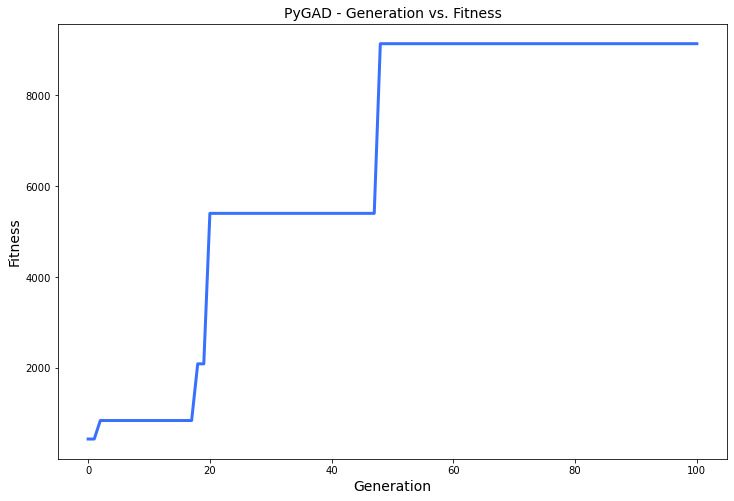

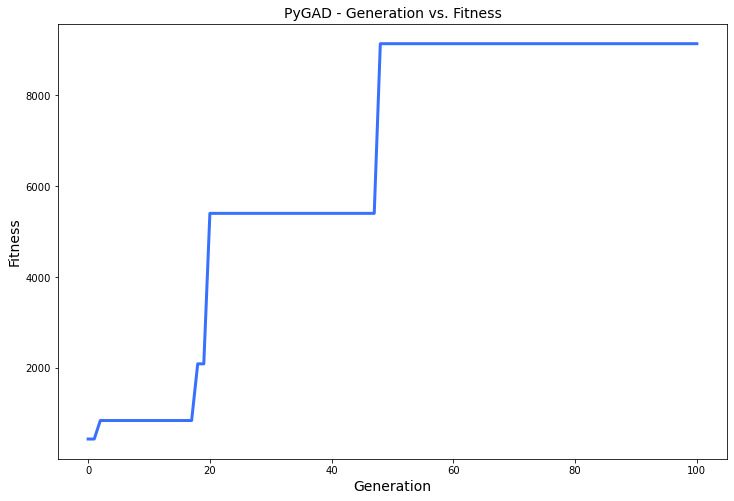

In [13]:
ga_instance.plot_result()

In [14]:
# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness)) 
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.23 |===========| 26.583 |==================| 23.68 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.069 |===========| 26.607 |==================| 14.933 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.188 |===========| 26.43 |==================| 9.086 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.101 |===========| 26.444 |==================| 10.427 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.429 |===========| 26.552 |==================| 89.2 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.516 |===========| 26.538 |==================| 407.404 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.779 |===========| 26.496 |===============

In [15]:
# Check the model's prediction
prediction = numpy.sum(numpy.array(water_model.function_inputs)*solution)
print("Predicted output based on the best solution :{prediction}".format(prediction=prediction))

if ga_instance.best_solution_generation != -1:
    print("Best fitness value reached after {best_solution_generation} generations.".format(best_solution_generation=ga_instance.best_solution_generation))


Predicted output based on the best solution :0.24965526950362132
Best fitness value reached after 48 generations.


In [16]:
# Check solution for confirmation
wn = wntr.network.WaterNetworkModel(water_model.inp_file_path)
results = water_model.change_discharge_coefficient(wn, emitter_value=abs(solution[0]))

pressure = results.node['pressure']
presssure_at_N6 = pressure.loc[:,water_model.node]
print(presssure_at_N6)

0    26.540466
Name: N6, dtype: float64


In [17]:
# Merge all our solutions per generation
solution_per_generation = glob.glob(f"{water_model.temp_dir}/GENERATION_*")
water_model.export_results(solutions = solution_per_generation, path='results', name='optimization-result-per-generation')
result_generation = pd.read_csv('results/optimization-result-per-generation.csv')
result_generation

File Exported Successfully to path: results/optimization-result-per-generation.csv


GENERATION      FITNESS
0         13.0   847.176602
1         12.0   847.176602
2         38.0  5406.269744
3         10.0   847.176602
4          9.0   847.176602
..         ...          ...
95        37.0  5406.269744
96         6.0   847.176602
97         7.0   847.176602
98        36.0  5406.269744
99        22.0  5406.269744

[100 rows x 2 columns]

In [18]:
fitness_solution_per_population = glob.glob(f"{water_model.temp_dir}/FITNESS_SOLUTION_*")

water_model.export_results(solutions = fitness_solution_per_population, path='results', name='optimization-result-per-fitness')
fitness_solution_per_population = pd.read_csv('results/optimization-result-per-fitness.csv')
fitness_solution_per_population

File Exported Successfully to path: results/optimization-result-per-fitness.csv


EMITTER_COEFFICIENT_SOLUTION  PRESSURE_OUTPUT  OUTPUT_DEMAND     FITNESS
0                         0.193313        26.588191           10.1   20.905291
1                         0.125533        26.598657           10.1   17.152367
2                         0.797707        26.493185           10.1   21.198248
3                         0.002500        26.617557           10.1   12.953287
4                         0.481753        26.543225           10.1  348.596275
...                            ...              ...            ...         ...
1915                      1.357678        26.402520           10.1    7.254853
1916                      1.474889        26.383227           10.1    6.364119
1917                      1.406989        26.394416           10.1    6.852041
1918                      0.018557        26.615098           10.1   13.379496
1919                      0.462876        26.546189           10.1  171.453447

[1920 rows x 4 columns]

In [19]:
final_data = pd.merge(fitness_solution_per_population,result_generation, how='left',left_on='FITNESS',right_on='FITNESS')
final_data = final_data.sort_values(by='FITNESS',ascending=True)
final_data

EMITTER_COEFFICIENT_SOLUTION  PRESSURE_OUTPUT  OUTPUT_DEMAND  \
1436                      1.503379        26.378522           10.1   
1192                      1.502597        26.378651           10.1   
1734                      1.498330        26.379356           10.1   
1067                      1.495503        26.379823           10.1   
1069                      1.493232        26.380198           10.1   
...                            ...              ...            ...   
1592                      0.499311        26.540466           10.1   
1593                      0.499311        26.540466           10.1   
1594                      0.499311        26.540466           10.1   
1569                      0.499311        26.540466           10.1   
1583                      0.499311        26.540466           10.1   

          FITNESS  GENERATION  
1436     6.179074         NaN  
1192     6.184012         NaN  
1734     6.211098         NaN  
1067     6.229168         NaN  
1069     6.243759         NaN  
...           ...         ...  
1592  9140.241342        60.0  
1593  9140.241342        79.0  
1594  9140.241342        51.0  
1569  9140.241342        58.0  
1583  9140.241342        89.0  

[2014 rows x 5 columns]

In [20]:
# Get a summary statistics after optimization
final_data.describe()

EMITTER_COEFFICIENT_SOLUTION  PRESSURE_OUTPUT  OUTPUT_DEMAND  \
count                   2014.000000      2014.000000   2.014000e+03   
mean                       0.606560        26.522820   1.010000e+01   
std                        0.425073         0.067574   7.640231e-14   
min                        0.002109        26.378522   1.010000e+01   
25%                        0.257101        26.469465   1.010000e+01   
50%                        0.499311        26.540466   1.010000e+01   
75%                        0.945711        26.578306   1.010000e+01   
max                        1.503379        26.617617   1.010000e+01   

           FITNESS  GENERATION  
count  2014.000000   99.000000  
mean    370.093419   50.989899  
std    1582.295553   28.740391  
min       6.179074    1.000000  
25%      13.245757   26.500000  
50%      20.388832   51.000000  
75%      42.124988   75.500000  
max    9140.241342  100.000000

In [21]:
# Check if there are missing values after optimization?
final_data.isna().sum()

EMITTER_COEFFICIENT_SOLUTION       0
PRESSURE_OUTPUT                    0
OUTPUT_DEMAND                      0
FITNESS                            0
GENERATION                      1915
dtype: int64

## Plot Results

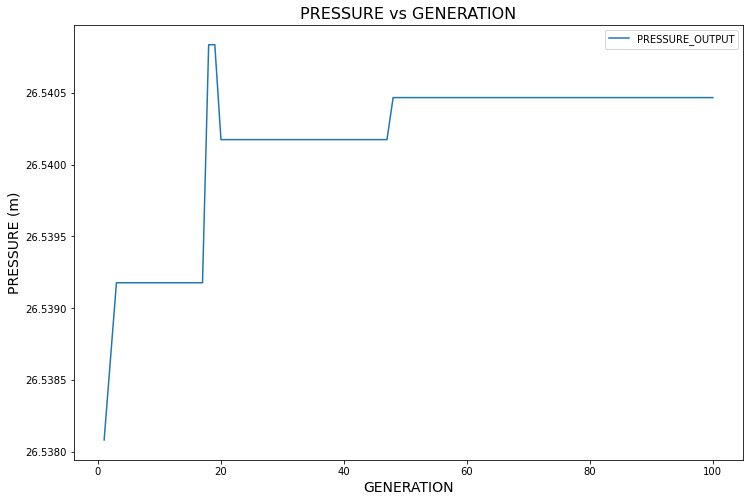

In [22]:
final_data.groupby(['GENERATION'])['PRESSURE_OUTPUT'].min().to_frame().plot()
plt.xlabel('GENERATION',fontsize=14)
plt.ylabel('PRESSURE (m)',fontsize=14)
plt.title('PRESSURE vs GENERATION',fontsize=16)
plt.savefig(water_model.plots_dir+"/PRESSURE_VS_GENERATION.png")
plt.show();
plt.close()

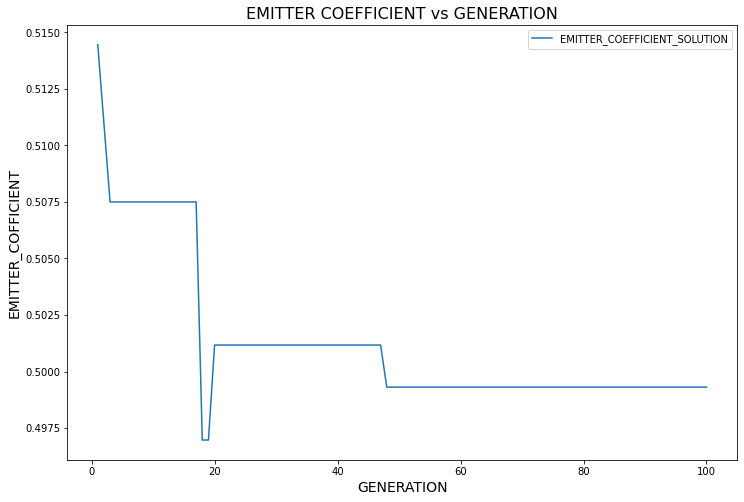

<Figure size 864x576 with 0 Axes>

In [23]:
final_data.groupby(['GENERATION'])['EMITTER_COEFFICIENT_SOLUTION'].min().to_frame().plot()
plt.xlabel('GENERATION',fontsize=14)
plt.ylabel('EMITTER_COFFICIENT',fontsize=14)
plt.title('EMITTER COEFFICIENT vs GENERATION',fontsize=16)
plt.show();
plt.savefig(f"{water_model.plots_dir}/EMITTER_COEFFICIENT.png");

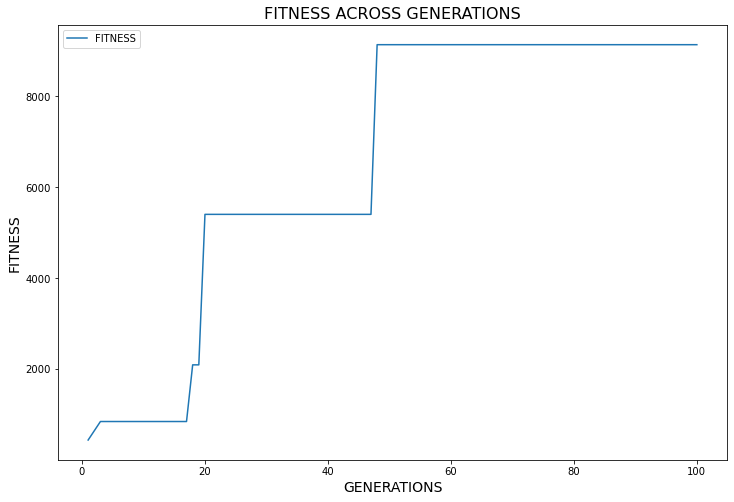

In [24]:
final_data.groupby(['GENERATION'])['FITNESS'].min().to_frame().plot()
plt.xlabel('GENERATIONS',fontsize=14) ### population
plt.ylabel('FITNESS',fontsize=14)
plt.title('FITNESS ACROSS GENERATIONS',fontsize=16)
plt.show();
plt.savefig(f"{water_model.plots_dir}/FITNESS_GEN.png")
plt.close()

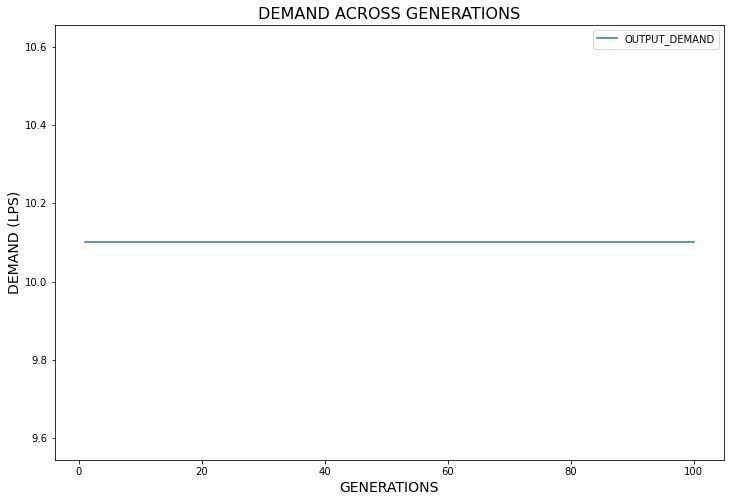

In [25]:
final_data.groupby(['GENERATION'])['OUTPUT_DEMAND'].min().to_frame().plot()
plt.xlabel('GENERATIONS',fontsize=14) ### population
plt.ylabel('DEMAND (LPS)',fontsize=14)
plt.title('DEMAND ACROSS GENERATIONS',fontsize=16)
plt.show();
plt.savefig(f"{water_model.plots_dir}/DEMAND_VS_GEN.png")
plt.close()

## NEXT STEPS:
* Add leak and  optimize for another node outside node 6 and make plots.
* Check if it will detect leak for a node without leak, maybe with NODE 2

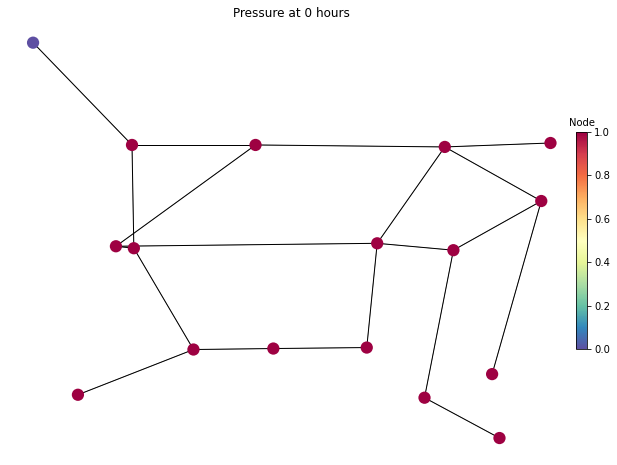

In [56]:
# Add leak and optimize for another node outside node 6 and make plots.
water_model2 = WaterLeakModel(node='N2')
water_model2.run()

In [57]:
def fitness_function(solution, solution_idx):
        
    wn = wntr.network.WaterNetworkModel(water_model2.inp_file_path)
    results = water_model2.change_discharge_coefficient(wn, emitter_value=abs(solution[0])) #change emitter coefficient

    pressure = results.node['pressure']
    pressure_output = pressure.loc[:,water_model2.node]
    
    demands=results.node['demand']
    demand_output = demands.loc[:,water_model2.node]

    fitness = 1.0 / (np.abs(pressure_output - water_model2.desired_output) + 0.000001)

    # Structure and export the output of the fitness
    data = pd.DataFrame(columns=['EMITTER_COEFFICIENT_SOLUTION','PRESSURE_OUTPUT','OUTPUT_DEMAND','FITNESS'])
    data = data.append({'EMITTER_COEFFICIENT_SOLUTION':abs(solution[0]),'PRESSURE_OUTPUT':list(pressure_output)[0],'FITNESS':list(fitness)[0],'OUTPUT_DEMAND':(list(demand_output) [0]*1000)},ignore_index=True)
    data.to_csv(f"{water_model2.temp_dir}/FITNESS_SOLUTION_{str(abs(solution[0]))}.csv",index=False) 

    print('=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========')
    print ('======|', abs(round(solution[0],3)),'|===========|',list(round(pressure_output,3))[0],'|==================|',list(round(fitness, 3))[0],'|==========')
    print('================================='*2)

    return list(fitness)[0]

In [58]:
#################### Create a Callback Function ########################
last_fitness = 0
def callback_generation(ga_instance): # This function prints algorithm progress
    global last_fitness
    print("Generation = {generation}".format(generation=ga_instance.generations_completed)) 
    print("Fitness = {fitness}".format(fitness=ga_instance.best_solution()[1]))
    print("Change = {change}".format(change=ga_instance.best_solution()[1] - last_fitness)) 

    data =pd.DataFrame(columns=['GENERATION','FITNESS'])
    data =data.append({'GENERATION':ga_instance.generations_completed,'FITNESS': ga_instance.best_solution ()[1]},ignore_index=True)
    data.to_csv(f"{water_model2.temp_dir}/GENERATION_{str(ga_instance.generations_completed)}.csv",index=False) 
    last_fitness = ga_instance.best_solution()[1]

In [59]:
# Instantiate the pygad optimization class
ga_instance2 = pygad.GA(num_generations=water_model2.num_generations,
                       num_parents_mating=water_model2.num_parents_mating, 
                       fitness_func=fitness_function, 
                       sol_per_pop=water_model2.sol_per_pop,
                       num_genes=water_model2.num_genes,
                       init_range_low=water_model2.init_range_low,
                       init_range_high=water_model2.init_range_high,
                       parent_selection_type=water_model2.parent_selection_type,
                       keep_parents=water_model2.keep_parents,
                       crossover_type=water_model2.crossover_type,
                       mutation_type=water_model2.mutation_type,
                       mutation_num_genes=water_model2.mutation_num_genes,
                       callback_generation=callback_generation)

In [ ]:
ga_instance2.run()

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.288 |===========| 24.838 |==================| 41.95 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.847 |===========| 24.775 |==================| 25.373 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.535 |===========| 24.81 |==================| 250.825 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.762 |===========| 24.785 |==================| 33.601 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.782 |===========| 24.782 |==================| 31.265 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.167 |===========| 24.852 |==================| 26.743 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.458 |===========| 24.819 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.302 |===========| 24.837 |==================| 44.834 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.232 |===========| 24.844 |==================| 33.245 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.15 |===========| 24.74 |==================| 13.47 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.634 |===========| 24.799 |==================| 65.799 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.025 |===========| 24.755 |==================| 16.714 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.152 |===========| 24.853 |==================| 25.597 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.645 |===========| 24.798 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.232 |===========| 24.844 |==================| 33.245 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.15 |===========| 24.74 |==================| 13.47 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.634 |===========| 24.799 |==================| 65.799 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.025 |===========| 24.755 |==================| 16.714 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.152 |===========| 24.853 |==================| 25.597 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.645 |===========| 24.798 |==================| 60.955 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.122 |===========| 24.857 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.44 |===========| 24.706 |==================| 9.265 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.637 |===========| 24.799 |==================| 64.307 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.413 |===========| 24.71 |==================| 9.547 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.607 |===========| 24.802 |==================| 82.364 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.092 |===========| 24.86 |==================| 21.88 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.508 |===========| 24.813 |==================| 1048.444 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.321 |===========| 24.835 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.413 |===========| 24.71 |==================| 9.547 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.607 |===========| 24.802 |==================| 82.364 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.092 |===========| 24.86 |==================| 21.88 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.508 |===========| 24.813 |==================| 1048.444 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.321 |===========| 24.835 |==================| 49.626 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.917 |===========| 24.767 |==================| 21.088 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.751 |===========| 24.786 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.092 |===========| 24.86 |==================| 21.88 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.508 |===========| 24.813 |==================| 1048.444 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.321 |===========| 24.835 |==================| 49.626 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.917 |===========| 24.767 |==================| 21.088 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.751 |===========| 24.786 |==================| 35.129 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.133 |===========| 24.856 |==================| 24.265 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.042 |===========| 24.753 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.246 |===========| 24.843 |==================| 35.071 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.232 |===========| 24.731 |==================| 11.943 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.053 |===========| 24.751 |==================| 15.848 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.061 |===========| 24.864 |==================| 20.353 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.254 |===========| 24.842 |==================| 36.228 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.035 |===========| 24.753 |==================| 16.391 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.582 |===========| 24.805 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.053 |===========| 24.751 |==================| 15.848 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.061 |===========| 24.864 |==================| 20.353 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.254 |===========| 24.842 |==================| 36.228 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.035 |===========| 24.753 |==================| 16.391 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.582 |===========| 24.805 |==================| 107.859 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.044 |===========| 24.866 |==================| 19.569 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.378 |===========| 24.828 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.175 |===========| 24.851 |==================| 27.406 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.089 |===========| 24.747 |==================| 14.889 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.052 |===========| 24.751 |==================| 15.892 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.347 |===========| 24.717 |==================| 10.299 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.397 |===========| 24.826 |==================| 86.018 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.51 |===========| 24.813 |==================| 867.232 |==========
Generation = 4
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.423 |===========| 24.

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.052 |===========| 24.751 |==================| 15.892 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.347 |===========| 24.717 |==================| 10.299 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.397 |===========| 24.826 |==================| 86.018 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.51 |===========| 24.813 |==================| 867.232 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.423 |===========| 24.709 |==================| 9.442 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.035 |===========| 24.753 |==================| 16.414 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.229 |===========| 24.845

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.51 |===========| 24.813 |==================| 867.232 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.072 |===========| 24.749 |==================| 15.319 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.357 |===========| 24.831 |==================| 61.99 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.456 |===========| 24.819 |==================| 202.481 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.056 |===========| 24.864 |==================| 20.113 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.284 |===========| 24.839 |==================| 41.099 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.327 |===========| 24.834 |==========

Fitness = 37875.07237294701
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.072 |===========| 24.749 |==================| 15.319 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.357 |===========| 24.831 |==================| 61.99 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.456 |===========| 24.819 |==================| 202.481 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.056 |===========| 24.864 |==================| 20.113 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.284 |===========| 24.839 |==================| 41.099 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.327 |===========| 24.834 |==================| 51.246 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.069 |===

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.357 |===========| 24.831 |==================| 61.99 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.456 |===========| 24.819 |==================| 202.481 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.056 |===========| 24.864 |==================| 20.113 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.284 |===========| 24.839 |==================| 41.099 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.327 |===========| 24.834 |==================| 51.246 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.069 |===========| 24.863 |==================| 20.692 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.593 |===========| 24.804 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.142 |===========| 24.741 |==================| 13.637 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.015 |===========| 24.869 |==================| 18.435 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.215 |===========| 24.733 |==================| 12.238 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.236 |===========| 24.844 |==================| 33.671 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.744 |===========| 24.787 |==================| 36.21 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.877 |===========| 24.772 |==================| 23.307 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.75 |===========| 24.786 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.236 |===========| 24.844 |==================| 33.671 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.744 |===========| 24.787 |==================| 36.21 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.877 |===========| 24.772 |==================| 23.307 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.75 |===========| 24.786 |==================| 35.324 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.074 |===========| 24.749 |==================| 15.278 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.218 |===========| 24.846 |==================| 31.593 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.455 |===========| 24.82 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.192 |===========| 24.849 |==================| 28.934 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.228 |===========| 24.845 |==================| 32.761 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.331 |===========| 24.833 |==================| 52.581 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.373 |===========| 24.829 |==================| 70.122 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.186 |===========| 24.85 |==================| 28.348 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.1 |===========| 24.859 |==================| 22.324 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.3 |===========| 24.837 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.331 |===========| 24.833 |==================| 52.581 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.373 |===========| 24.829 |==================| 70.122 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.186 |===========| 24.85 |==================| 28.348 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.1 |===========| 24.859 |==================| 22.324 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.3 |===========| 24.837 |==================| 44.413 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.434 |===========| 24.707 |==================| 9.331 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.618 |===========| 24.801 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.186 |===========| 24.85 |==================| 28.348 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.1 |===========| 24.859 |==================| 22.324 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.3 |===========| 24.837 |==================| 44.413 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.434 |===========| 24.707 |==================| 9.331 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.618 |===========| 24.801 |==================| 74.702 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.796 |===========| 24.781 |==================| 29.756 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.429 |===========| 24.708 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.132 |===========| 24.856 |==================| 24.226 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.378 |===========| 24.714 |==================| 9.937 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.932 |===========| 24.765 |==================| 20.351 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.382 |===========| 24.828 |==================| 74.94 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.409 |===========| 24.825 |==================| 97.452 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.521 |===========| 24.812 |==================| 419.5 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.976 |===========| 24.76 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.382 |===========| 24.828 |==================| 74.94 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.409 |===========| 24.825 |==================| 97.452 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.521 |===========| 24.812 |==================| 419.5 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.976 |===========| 24.76 |==================| 18.467 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.018 |===========| 24.755 |==================| 16.943 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.055 |===========| 24.751 |==================| 15.8 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.901 |===========| 24.769 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.286 |===========| 24.838 |==================| 41.612 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.02 |===========| 24.755 |==================| 16.888 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.192 |===========| 24.849 |==================| 28.905 |==========
Generation = 9
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.441 |===========| 24.821 |==================| 149.818 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.478 |===========| 24.817 |==================| 408.766 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.562 |===========| 24.807 |==================| 143.647 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.486 |===========| 2

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.441 |===========| 24.821 |==================| 149.818 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.478 |===========| 24.817 |==================| 408.766 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.562 |===========| 24.807 |==================| 143.647 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.486 |===========| 24.701 |==================| 8.826 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.108 |===========| 24.745 |==================| 14.403 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.403 |===========| 24.825 |==================| 91.723 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.298 |===========| 24.837 |========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.541 |===========| 24.81 |==================| 217.031 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.091 |===========| 24.86 |==================| 21.829 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.295 |===========| 24.723 |==================| 10.981 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.368 |===========| 24.715 |==================| 10.056 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.073 |===========| 24.862 |==================| 20.925 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.703 |===========| 24.791 |==================| 43.436 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.03 |===========| 24.867 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.368 |===========| 24.715 |==================| 10.056 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.073 |===========| 24.862 |==================| 20.925 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.703 |===========| 24.791 |==================| 43.436 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.03 |===========| 24.867 |==================| 18.996 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.209 |===========| 24.847 |==================| 30.57 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.029 |===========| 24.867 |==================| 18.958 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.08 |===========| 24.861 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.03 |===========| 24.867 |==================| 18.996 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.209 |===========| 24.847 |==================| 30.57 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.029 |===========| 24.867 |==================| 18.958 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.08 |===========| 24.861 |==================| 21.262 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.409 |===========| 24.825 |==================| 97.587 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.818 |===========| 24.778 |==================| 27.665 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.065 |===========| 24.75 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.625 |===========| 24.8 |==================| 70.9 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.357 |===========| 24.716 |==================| 10.178 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.756 |===========| 24.785 |==================| 34.419 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.669 |===========| 24.795 |==================| 52.308 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.283 |===========| 24.839 |==================| 41.016 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.328 |===========| 24.834 |==================| 51.794 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.327 |===========| 24.72 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.756 |===========| 24.785 |==================| 34.419 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.669 |===========| 24.795 |==================| 52.308 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.283 |===========| 24.839 |==================| 41.016 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.328 |===========| 24.834 |==================| 51.794 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.327 |===========| 24.72 |==================| 10.555 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.452 |===========| 24.705 |==================| 9.149 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.623 |===========| 24.8 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.296 |===========| 24.837 |==================| 43.66 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.311 |===========| 24.836 |==================| 47.042 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.156 |===========| 24.739 |==================| 13.343 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.874 |===========| 24.772 |==================| 23.499 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.182 |===========| 24.737 |==================| 12.841 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.85 |===========| 24.775 |==================| 25.147 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.253 |===========| 24.842 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.311 |===========| 24.836 |==================| 47.042 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.156 |===========| 24.739 |==================| 13.343 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.874 |===========| 24.772 |==================| 23.499 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.182 |===========| 24.737 |==================| 12.841 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.85 |===========| 24.775 |==================| 25.147 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.253 |===========| 24.842 |==================| 36.084 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.218 |===========| 24.846

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.156 |===========| 24.739 |==================| 13.343 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.874 |===========| 24.772 |==================| 23.499 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.182 |===========| 24.737 |==================| 12.841 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.85 |===========| 24.775 |==================| 25.147 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.253 |===========| 24.842 |==================| 36.084 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.285 |===========| 24.839 |==================| 41.381 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.63 |===========| 24.8 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.166 |===========| 24.852 |==================| 26.658 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.912 |===========| 24.768 |==================| 21.317 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.24 |===========| 24.844 |==================| 34.173 |==========
Fitness = 37875.07237294701
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.285 |===========| 24.839 |==================| 41.381 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.63 |===========| 24.8 |==================| 67.887 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.023 |===========| 24.868 |==================| 18.731 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.663 |=======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.24 |===========| 24.844 |==================| 34.173 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.285 |===========| 24.839 |==================| 41.381 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.63 |===========| 24.8 |==================| 67.887 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.023 |===========| 24.868 |==================| 18.731 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.663 |===========| 24.796 |==================| 54.028 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.612 |===========| 24.802 |==================| 79.035 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.862 |===========| 24.773 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.322 |===========| 24.834 |==================| 49.925 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.266 |===========| 24.841 |==================| 38.087 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.488 |===========| 24.816 |==================| 762.468 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.258 |===========| 24.842 |==================| 36.833 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.381 |===========| 24.828 |==================| 74.728 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.389 |===========| 24.827 |==================| 80.061 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.788 |===========| 24.782 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.258 |===========| 24.842 |==================| 36.833 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.381 |===========| 24.828 |==================| 74.728 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.389 |===========| 24.827 |==================| 80.061 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.788 |===========| 24.782 |==================| 30.598 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.035 |===========| 24.866 |==================| 19.215 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.456 |===========| 24.819 |==================| 203.572 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.489 |===========| 24.816 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.306 |===========| 24.722 |==================| 10.841 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.537 |===========| 24.81 |==================| 238.772 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.468 |===========| 24.818 |==================| 276.943 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.194 |===========| 24.735 |==================| 12.6 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.552 |===========| 24.809 |==================| 169.686 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.211 |===========| 24.733 |==================| 12.295 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.394 |===========| 24.826 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.537 |===========| 24.81 |==================| 238.772 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.468 |===========| 24.818 |==================| 276.943 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.194 |===========| 24.735 |==================| 12.6 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.552 |===========| 24.809 |==================| 169.686 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.211 |===========| 24.733 |==================| 12.295 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.394 |===========| 24.826 |==================| 84.005 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.049 |===========| 24.865 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.194 |===========| 24.735 |==================| 12.6 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.552 |===========| 24.809 |==================| 169.686 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.211 |===========| 24.733 |==================| 12.295 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.394 |===========| 24.826 |==================| 84.005 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.049 |===========| 24.865 |==================| 19.82 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.037 |===========| 24.866 |==================| 19.286 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.011 |===========| 24.869 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.113 |===========| 24.858 |==================| 23.073 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.065 |===========| 24.863 |==================| 20.536 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.037 |===========| 24.866 |==================| 19.271 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.518 |===========| 24.812 |==================| 504.625 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.487 |===========| 24.701 |==================| 8.824 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.279 |===========| 24.725 |==================| 11.215 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.455 |===========| 24.82 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.037 |===========| 24.866 |==================| 19.271 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.518 |===========| 24.812 |==================| 504.625 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.487 |===========| 24.701 |==================| 8.824 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.279 |===========| 24.725 |==================| 11.215 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.455 |===========| 24.82 |==================| 195.602 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.345 |===========| 24.832 |==================| 57.231 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.717 |===========| 24.79 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.126 |===========| 24.856 |==================| 23.851 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.456 |===========| 24.705 |==================| 9.111 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.266 |===========| 24.841 |==================| 38.076 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.03 |===========| 24.867 |==================| 19.006 |==========
Generation = 17
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.482 |===========| 24.816 |==================| 501.253 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.246 |===========| 24.729 |==================| 11.719 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.107 |===========| 24.

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.266 |===========| 24.841 |==================| 38.076 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.03 |===========| 24.867 |==================| 19.006 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.482 |===========| 24.816 |==================| 501.253 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.246 |===========| 24.729 |==================| 11.719 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.107 |===========| 24.858 |==================| 22.693 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.093 |===========| 24.747 |==================| 14.787 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.956 |===========| 24.76

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.251 |===========| 24.842 |==================| 35.792 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.599 |===========| 24.803 |==================| 89.155 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.444 |===========| 24.706 |==================| 9.225 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.494 |===========| 24.815 |==================| 1407.83 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.469 |===========| 24.703 |==================| 8.985 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.072 |===========| 24.862 |==================| 20.865 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.898 |===========| 24.769 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.494 |===========| 24.815 |==================| 1407.83 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.469 |===========| 24.703 |==================| 8.985 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.072 |===========| 24.862 |==================| 20.865 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.898 |===========| 24.769 |==================| 22.116 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.48 |===========| 24.702 |==================| 8.884 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.376 |===========| 24.828 |==================| 71.477 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.176 |===========| 24.851 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.469 |===========| 24.703 |==================| 8.985 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.072 |===========| 24.862 |==================| 20.865 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.898 |===========| 24.769 |==================| 22.116 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.48 |===========| 24.702 |==================| 8.884 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.376 |===========| 24.828 |==================| 71.477 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.176 |===========| 24.851 |==================| 27.508 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.046 |===========| 24.752 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.615 |===========| 24.801 |==================| 77.019 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.197 |===========| 24.848 |==================| 29.377 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.351 |===========| 24.831 |==================| 59.771 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.235 |===========| 24.844 |==================| 33.551 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.413 |===========| 24.824 |==================| 101.571 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.113 |===========| 24.744 |==================| 14.302 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.093 |===========| 24.747 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.197 |===========| 24.848 |==================| 29.377 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.351 |===========| 24.831 |==================| 59.771 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.235 |===========| 24.844 |==================| 33.551 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.413 |===========| 24.824 |==================| 101.571 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.113 |===========| 24.744 |==================| 14.302 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.093 |===========| 24.747 |==================| 14.777 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.353 |===========| 24.717 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.456 |===========| 24.819 |==================| 202.167 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.129 |===========| 24.743 |==================| 13.923 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.414 |===========| 24.824 |==================| 103.158 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.166 |===========| 24.852 |==================| 26.703 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.08 |===========| 24.861 |==================| 21.262 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.46 |===========| 24.819 |==================| 223.612 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.58 |===========| 24.805 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.129 |===========| 24.743 |==================| 13.923 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.414 |===========| 24.824 |==================| 103.158 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.166 |===========| 24.852 |==================| 26.703 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.08 |===========| 24.861 |==================| 21.262 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.46 |===========| 24.819 |==================| 223.612 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.58 |===========| 24.805 |==================| 110.998 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.998 |===========| 24.758 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.414 |===========| 24.824 |==================| 103.158 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.166 |===========| 24.852 |==================| 26.703 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.08 |===========| 24.861 |==================| 21.262 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.46 |===========| 24.819 |==================| 223.612 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.58 |===========| 24.805 |==================| 110.998 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.998 |===========| 24.758 |==================| 17.621 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.462 |===========| 24.704 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.375 |===========| 24.829 |==================| 70.959 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.172 |===========| 24.738 |==================| 13.029 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.705 |===========| 24.791 |==================| 43.146 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.711 |===========| 24.791 |==================| 41.827 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.215 |===========| 24.733 |==================| 12.227 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.285 |===========| 24.839 |==================| 41.304 |==========
Fitness = 37875.07237294701
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.274 |===

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.172 |===========| 24.738 |==================| 13.029 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.705 |===========| 24.791 |==================| 43.146 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.711 |===========| 24.791 |==================| 41.827 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.215 |===========| 24.733 |==================| 12.227 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.285 |===========| 24.839 |==================| 41.304 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.274 |===========| 24.84 |==================| 39.312 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.771 |===========| 24.784 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.983 |===========| 24.759 |==================| 18.175 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.488 |===========| 24.816 |==================| 750.118 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.652 |===========| 24.797 |==================| 58.23 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.238 |===========| 24.844 |==================| 33.952 |==========
Generation = 22
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.676 |===========| 24.794 |==================| 50.185 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.383 |===========| 24.828 |==================| 76.125 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.0 |===========| 24.8

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.488 |===========| 24.816 |==================| 750.118 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.652 |===========| 24.797 |==================| 58.23 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.238 |===========| 24.844 |==================| 33.952 |==========
Change = 12865.786459550647
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.676 |===========| 24.794 |==================| 50.185 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.383 |===========| 24.828 |==================| 76.125 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.0 |===========| 24.87 |==================| 17.891 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.435 |======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.238 |===========| 24.844 |==================| 33.952 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.278 |===========| 24.839 |==================| 39.974 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.315 |===========| 24.721 |==================| 10.709 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.856 |===========| 24.774 |==================| 24.732 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.336 |===========| 24.833 |==================| 54.172 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.908 |===========| 24.768 |==================| 21.559 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.494 |===========| 24.7 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.856 |===========| 24.774 |==================| 24.732 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.336 |===========| 24.833 |==================| 54.172 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.908 |===========| 24.768 |==================| 21.559 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.494 |===========| 24.7 |==================| 8.762 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.113 |===========| 24.858 |==================| 23.055 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.162 |===========| 24.739 |==================| 13.223 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.343 |===========| 24.832 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.908 |===========| 24.768 |==================| 21.559 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.494 |===========| 24.7 |==================| 8.762 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.113 |===========| 24.858 |==================| 23.055 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.162 |===========| 24.739 |==================| 13.223 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.343 |===========| 24.832 |==================| 56.496 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.549 |===========| 24.809 |==================| 181.967 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.084 |===========| 24.748 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.759 |===========| 24.785 |==================| 33.989 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.132 |===========| 24.856 |==================| 24.235 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.989 |===========| 24.759 |==================| 17.961 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.49 |===========| 24.816 |==================| 844.268 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.227 |===========| 24.845 |==================| 32.636 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.489 |===========| 24.816 |==================| 801.807 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.067 |===========| 24.863 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.132 |===========| 24.856 |==================| 24.235 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.989 |===========| 24.759 |==================| 17.961 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.49 |===========| 24.816 |==================| 844.268 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.227 |===========| 24.845 |==================| 32.636 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.489 |===========| 24.816 |==================| 801.807 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.067 |===========| 24.863 |==================| 20.62 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.245 |===========| 24.843 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.416 |===========| 24.824 |==================| 105.562 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.008 |===========| 24.869 |==================| 18.163 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.276 |===========| 24.84 |==================| 39.769 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.119 |===========| 24.857 |==================| 23.411 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.933 |===========| 24.765 |==================| 20.322 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.308 |===========| 24.722 |==================| 10.805 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.057 |===========| 24.864 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.008 |===========| 24.869 |==================| 18.163 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.276 |===========| 24.84 |==================| 39.769 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.119 |===========| 24.857 |==================| 23.411 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.933 |===========| 24.765 |==================| 20.322 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.308 |===========| 24.722 |==================| 10.805 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.057 |===========| 24.864 |==================| 20.174 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.684 |===========| 24.794 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.276 |===========| 24.84 |==================| 39.769 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.119 |===========| 24.857 |==================| 23.411 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.933 |===========| 24.765 |==================| 20.322 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.308 |===========| 24.722 |==================| 10.805 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.057 |===========| 24.864 |==================| 20.174 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.684 |===========| 24.794 |==================| 48.0 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.028 |===========| 24.867 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.894 |===========| 24.77 |==================| 22.343 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.338 |===========| 24.833 |==================| 54.868 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.48 |===========| 24.817 |==================| 453.832 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.278 |===========| 24.839 |==================| 40.072 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.528 |===========| 24.811 |==================| 313.013 |==========
Fitness = 50740.85883249766
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.473 |===========| 24.817 |==================| 331.656 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.572 |==

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.278 |===========| 24.839 |==================| 40.072 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.528 |===========| 24.811 |==================| 313.013 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.473 |===========| 24.817 |==================| 331.656 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.572 |===========| 24.806 |==================| 122.466 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.479 |===========| 24.702 |==================| 8.895 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.412 |===========| 24.824 |==================| 101.202 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.142 |===========| 24.855 |=======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.824 |===========| 24.778 |==================| 27.14 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.703 |===========| 24.791 |==================| 43.441 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.714 |===========| 24.79 |==================| 41.324 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.122 |===========| 24.743 |==================| 14.09 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.069 |===========| 24.863 |==================| 20.701 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.158 |===========| 24.853 |==================| 26.057 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.04 |===========| 24.753 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.714 |===========| 24.79 |==================| 41.324 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.122 |===========| 24.743 |==================| 14.09 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.069 |===========| 24.863 |==================| 20.701 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.158 |===========| 24.853 |==================| 26.057 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.04 |===========| 24.753 |==================| 16.241 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.168 |===========| 24.852 |==================| 26.842 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.394 |===========| 24.826 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.205 |===========| 24.848 |==================| 30.154 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.294 |===========| 24.838 |==================| 43.243 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.842 |===========| 24.776 |==================| 25.753 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.097 |===========| 24.86 |==================| 22.122 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.463 |===========| 24.819 |==================| 239.287 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.085 |===========| 24.861 |==================| 21.522 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.748 |===========| 24.786 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.294 |===========| 24.838 |==================| 43.243 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.842 |===========| 24.776 |==================| 25.753 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.097 |===========| 24.86 |==================| 22.122 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.463 |===========| 24.819 |==================| 239.287 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.085 |===========| 24.861 |==================| 21.522 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.748 |===========| 24.786 |==================| 35.507 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.362 |===========| 24.83 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.097 |===========| 24.86 |==================| 22.122 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.463 |===========| 24.819 |==================| 239.287 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.085 |===========| 24.861 |==================| 21.522 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.748 |===========| 24.786 |==================| 35.507 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.362 |===========| 24.83 |==================| 64.387 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.781 |===========| 24.782 |==================| 31.318 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.865 |===========| 24.773 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.22 |===========| 24.732 |==================| 12.138 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.431 |===========| 24.822 |==================| 128.721 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.002 |===========| 24.757 |==================| 17.475 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.034 |===========| 24.867 |==================| 19.163 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.502 |===========| 24.814 |==================| 5198.768 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.258 |===========| 24.842 |==================| 36.727 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.545 |===========| 24.809 |========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.002 |===========| 24.757 |==================| 17.475 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.034 |===========| 24.867 |==================| 19.163 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.502 |===========| 24.814 |==================| 5198.768 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.258 |===========| 24.842 |==================| 36.727 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.545 |===========| 24.809 |==================| 196.009 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.653 |===========| 24.797 |==================| 57.713 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.958 |===========| 24.762 |=======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.091 |===========| 24.86 |==================| 21.836 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.414 |===========| 24.824 |==================| 102.751 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.446 |===========| 24.82 |==================| 164.718 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.282 |===========| 24.725 |==================| 11.174 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.209 |===========| 24.847 |==================| 30.609 |==========
Generation = 30
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.548 |===========| 24.809 |==================| 182.44 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.03 |===========| 24.

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.446 |===========| 24.82 |==================| 164.718 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.282 |===========| 24.725 |==================| 11.174 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.209 |===========| 24.847 |==================| 30.609 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.548 |===========| 24.809 |==================| 182.44 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.03 |===========| 24.867 |==================| 18.993 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.688 |===========| 24.793 |==================| 46.991 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.385 |===========| 24.827

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.282 |===========| 24.725 |==================| 11.174 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.209 |===========| 24.847 |==================| 30.609 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.815 |===========| 24.779 |==================| 27.981 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.928 |===========| 24.766 |==================| 20.526 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.455 |===========| 24.82 |==================| 196.428 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.677 |===========| 24.794 |==================| 49.904 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.822 |===========| 24.778 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.805 |===========| 24.78 |==================| 28.923 |==========
Fitness = 50740.85883249766
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.815 |===========| 24.779 |==================| 27.981 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.928 |===========| 24.766 |==================| 20.526 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.455 |===========| 24.82 |==================| 196.428 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.677 |===========| 24.794 |==================| 49.904 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.822 |===========| 24.778 |==================| 27.324 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.272 |====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.815 |===========| 24.779 |==================| 27.981 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.928 |===========| 24.766 |==================| 20.526 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.455 |===========| 24.82 |==================| 196.428 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.677 |===========| 24.794 |==================| 49.904 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.822 |===========| 24.778 |==================| 27.324 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.272 |===========| 24.84 |==================| 39.044 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.283 |===========| 24.839 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.942 |===========| 24.764 |==================| 19.883 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.02 |===========| 24.755 |==================| 16.887 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.881 |===========| 24.771 |==================| 23.099 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.695 |===========| 24.792 |==================| 45.283 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.869 |===========| 24.773 |==================| 23.858 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.395 |===========| 24.826 |==================| 84.392 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.04 |===========| 24.753 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.881 |===========| 24.771 |==================| 23.099 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.695 |===========| 24.792 |==================| 45.283 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.869 |===========| 24.773 |==================| 23.858 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.395 |===========| 24.826 |==================| 84.392 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.04 |===========| 24.753 |==================| 16.25 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.268 |===========| 24.84 |==================| 38.4 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.082 |===========| 24.748 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.235 |===========| 24.844 |==================| 33.55 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.271 |===========| 24.84 |==================| 38.909 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.241 |===========| 24.843 |==================| 34.404 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.186 |===========| 24.736 |==================| 12.758 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.222 |===========| 24.846 |==================| 32.038 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.054 |===========| 24.751 |==================| 15.833 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.146 |===========| 24.854 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.186 |===========| 24.736 |==================| 12.758 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.222 |===========| 24.846 |==================| 32.038 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.054 |===========| 24.751 |==================| 15.833 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.146 |===========| 24.854 |==================| 25.159 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.088 |===========| 24.747 |==================| 14.911 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.098 |===========| 24.86 |==================| 22.173 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.094 |===========| 24.747 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.146 |===========| 24.854 |==================| 25.159 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.088 |===========| 24.747 |==================| 14.911 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.098 |===========| 24.86 |==================| 22.173 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.094 |===========| 24.747 |==================| 14.76 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.159 |===========| 24.853 |==================| 26.098 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.267 |===========| 24.841 |==================| 38.119 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.289 |===========| 24.724 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.174 |===========| 24.851 |==================| 27.302 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.873 |===========| 24.772 |==================| 23.58 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.105 |===========| 24.859 |==================| 22.574 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.102 |===========| 24.859 |==================| 22.424 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.225 |===========| 24.845 |==================| 32.32 |==========
Fitness = 50740.85883249766
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.344 |===========| 24.832 |==================| 57.111 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.344 |=====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.105 |===========| 24.859 |==================| 22.574 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.102 |===========| 24.859 |==================| 22.424 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.225 |===========| 24.845 |==================| 32.32 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.344 |===========| 24.832 |==================| 57.111 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.344 |===========| 24.832 |==================| 56.801 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.057 |===========| 24.864 |==================| 20.156 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.437 |===========| 24.822 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.319 |===========| 24.835 |==================| 49.194 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.606 |===========| 24.802 |==================| 83.678 |==========
Generation = 35
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.982 |===========| 24.759 |==================| 18.201 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.038 |===========| 24.753 |==================| 16.319 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.611 |===========| 24.802 |==================| 79.796 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.035 |===========| 24.866 |==================| 19.201 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.351 |===========| 24

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.606 |===========| 24.802 |==================| 83.678 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.982 |===========| 24.759 |==================| 18.201 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.038 |===========| 24.753 |==================| 16.319 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.611 |===========| 24.802 |==================| 79.796 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.035 |===========| 24.866 |==================| 19.201 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.351 |===========| 24.831 |==================| 59.475 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.261 |===========| 24.84

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.365 |===========| 24.83 |==================| 65.725 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.682 |===========| 24.794 |==================| 48.412 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.023 |===========| 24.868 |==================| 18.721 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.161 |===========| 24.739 |==================| 13.236 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.464 |===========| 24.818 |==================| 246.504 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.331 |===========| 24.833 |==================| 52.569 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.801 |===========| 24.78 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.161 |===========| 24.739 |==================| 13.236 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.464 |===========| 24.818 |==================| 246.504 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.331 |===========| 24.833 |==================| 52.569 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.801 |===========| 24.78 |==================| 29.24 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.225 |===========| 24.732 |==================| 12.061 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.497 |===========| 24.7 |==================| 8.731 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.452 |===========| 24.705 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.801 |===========| 24.78 |==================| 29.24 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.225 |===========| 24.732 |==================| 12.061 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.497 |===========| 24.7 |==================| 8.731 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.452 |===========| 24.705 |==================| 9.147 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.701 |===========| 24.792 |==================| 43.971 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.081 |===========| 24.861 |==================| 21.297 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.991 |===========| 24.758 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.492 |===========| 24.701 |==================| 8.779 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.051 |===========| 24.865 |==================| 19.892 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.613 |===========| 24.802 |==================| 78.003 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.176 |===========| 24.851 |==================| 27.518 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.13 |===========| 24.856 |==================| 24.119 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.13 |===========| 24.856 |==================| 24.066 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.269 |===========| 24.726 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.176 |===========| 24.851 |==================| 27.518 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.13 |===========| 24.856 |==================| 24.119 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.13 |===========| 24.856 |==================| 24.066 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.269 |===========| 24.726 |==================| 11.362 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.699 |===========| 24.792 |==================| 44.329 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.118 |===========| 24.744 |==================| 14.179 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.529 |===========| 24.811 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.262 |===========| 24.841 |==================| 37.344 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.064 |===========| 24.75 |==================| 15.549 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.149 |===========| 24.854 |==================| 25.401 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.842 |===========| 24.776 |==================| 25.712 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.595 |===========| 24.804 |==================| 92.999 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.185 |===========| 24.85 |==================| 28.315 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.371 |===========| 24.715 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.842 |===========| 24.776 |==================| 25.712 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.595 |===========| 24.804 |==================| 92.999 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.185 |===========| 24.85 |==================| 28.315 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.371 |===========| 24.715 |==================| 10.01 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.11 |===========| 24.858 |==================| 22.882 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.158 |===========| 24.739 |==================| 13.303 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.627 |===========| 24.8 |==

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.185 |===========| 24.85 |==================| 28.315 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.371 |===========| 24.715 |==================| 10.01 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.088 |===========| 24.861 |==================| 21.649 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.389 |===========| 24.827 |==================| 80.071 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.108 |===========| 24.858 |==================| 22.773 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.188 |===========| 24.849 |==================| 28.515 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.321 |===========| 24.835 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.639 |===========| 24.799 |==================| 63.745 |==========
Fitness = 82575.48879076121
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.088 |===========| 24.861 |==================| 21.649 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.389 |===========| 24.827 |==================| 80.071 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.108 |===========| 24.858 |==================| 22.773 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.188 |===========| 24.849 |==================| 28.515 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.321 |===========| 24.835 |==================| 49.703 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.147 |===

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.088 |===========| 24.861 |==================| 21.649 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.389 |===========| 24.827 |==================| 80.071 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.108 |===========| 24.858 |==================| 22.773 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.188 |===========| 24.849 |==================| 28.515 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.321 |===========| 24.835 |==================| 49.703 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.147 |===========| 24.854 |==================| 25.225 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.021 |===========| 24.755 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.329 |===========| 24.834 |==================| 51.991 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.793 |===========| 24.781 |==================| 30.036 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.037 |===========| 24.753 |==================| 16.328 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.318 |===========| 24.721 |==================| 10.673 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.397 |===========| 24.826 |==================| 86.258 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.367 |===========| 24.715 |==================| 10.064 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.484 |===========| 24.816 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.037 |===========| 24.753 |==================| 16.328 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.318 |===========| 24.721 |==================| 10.673 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.397 |===========| 24.826 |==================| 86.258 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.367 |===========| 24.715 |==================| 10.064 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.484 |===========| 24.816 |==================| 551.209 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.467 |===========| 24.818 |==================| 269.796 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.256 |===========| 24.842 |========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.296 |===========| 24.723 |==================| 10.975 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.272 |===========| 24.84 |==================| 39.005 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.002 |===========| 24.87 |==================| 17.933 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.928 |===========| 24.766 |==================| 20.52 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.046 |===========| 24.865 |==================| 19.682 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.556 |===========| 24.808 |==================| 158.189 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.001 |===========| 24.87 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.272 |===========| 24.84 |==================| 39.005 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.002 |===========| 24.87 |==================| 17.933 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.928 |===========| 24.766 |==================| 20.52 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.046 |===========| 24.865 |==================| 19.682 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.556 |===========| 24.808 |==================| 158.189 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.001 |===========| 24.87 |==================| 17.901 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.561 |===========| 24.808 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.928 |===========| 24.766 |==================| 20.52 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.046 |===========| 24.865 |==================| 19.682 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.556 |===========| 24.808 |==================| 158.189 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.001 |===========| 24.87 |==================| 17.901 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.561 |===========| 24.808 |==================| 145.033 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.416 |===========| 24.824 |==================| 105.599 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.063 |===========| 24.863 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.422 |===========| 24.823 |==================| 113.716 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.588 |===========| 24.805 |==================| 100.845 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.188 |===========| 24.849 |==================| 28.553 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.191 |===========| 24.849 |==================| 28.855 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.404 |===========| 24.825 |==================| 92.771 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.649 |===========| 24.797 |==================| 59.083 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.108 |===========| 24.858 |========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.188 |===========| 24.849 |==================| 28.553 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.191 |===========| 24.849 |==================| 28.855 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.404 |===========| 24.825 |==================| 92.771 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.649 |===========| 24.797 |==================| 59.083 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.108 |===========| 24.858 |==================| 22.758 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.001 |===========| 24.87 |==================| 17.911 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.662 |===========| 24.796 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.387 |===========| 24.827 |==================| 78.69 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.233 |===========| 24.844 |==================| 33.384 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.579 |===========| 24.806 |==================| 112.46 |==========
Generation = 43
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.12 |===========| 24.857 |==================| 23.459 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.381 |===========| 24.713 |==================| 9.899 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.379 |===========| 24.714 |==================| 9.921 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.969 |===========| 24.761

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.233 |===========| 24.844 |==================| 33.384 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.579 |===========| 24.806 |==================| 112.46 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.12 |===========| 24.857 |==================| 23.459 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.381 |===========| 24.713 |==================| 9.899 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.379 |===========| 24.714 |==================| 9.921 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.969 |===========| 24.761 |==================| 18.72 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.005 |===========| 24.757 |=

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.579 |===========| 24.806 |==================| 112.46 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.531 |===========| 24.811 |==================| 288.843 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.985 |===========| 24.759 |==================| 18.098 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.445 |===========| 24.821 |==================| 161.507 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.072 |===========| 24.862 |==================| 20.851 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.124 |===========| 24.743 |==================| 14.041 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.11 |===========| 24.858 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.985 |===========| 24.759 |==================| 18.098 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.445 |===========| 24.821 |==================| 161.507 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.072 |===========| 24.862 |==================| 20.851 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.124 |===========| 24.743 |==================| 14.041 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.11 |===========| 24.858 |==================| 22.853 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.264 |===========| 24.841 |==================| 37.726 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.477 |===========| 24.702 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.124 |===========| 24.743 |==================| 14.041 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.11 |===========| 24.858 |==================| 22.853 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.264 |===========| 24.841 |==================| 37.726 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.477 |===========| 24.702 |==================| 8.91 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.069 |===========| 24.749 |==================| 15.403 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.4 |===========| 24.711 |==================| 9.683 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.292 |===========| 24.838 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.011 |===========| 24.869 |==================| 18.287 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.831 |===========| 24.777 |==================| 26.606 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.077 |===========| 24.862 |==================| 21.114 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.781 |===========| 24.783 |==================| 31.385 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.447 |===========| 24.706 |==================| 9.198 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.155 |===========| 24.74 |==================| 13.378 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.858 |===========| 24.774 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.781 |===========| 24.783 |==================| 31.385 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.447 |===========| 24.706 |==================| 9.198 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.155 |===========| 24.74 |==================| 13.378 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.858 |===========| 24.774 |==================| 24.589 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.094 |===========| 24.747 |==================| 14.767 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.871 |===========| 24.772 |==================| 23.697 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.483 |===========| 24.816 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.526 |===========| 24.811 |==================| 336.389 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.322 |===========| 24.834 |==================| 49.888 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.294 |===========| 24.724 |==================| 11.001 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.078 |===========| 24.862 |==================| 21.151 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.339 |===========| 24.832 |==================| 55.31 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.399 |===========| 24.826 |==================| 88.276 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.437 |===========| 24.707 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.294 |===========| 24.724 |==================| 11.001 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.078 |===========| 24.862 |==================| 21.151 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.339 |===========| 24.832 |==================| 55.31 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.399 |===========| 24.826 |==================| 88.276 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.437 |===========| 24.707 |==================| 9.3 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.391 |===========| 24.712 |==================| 9.788 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.26 |===========| 24.841 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.399 |===========| 24.826 |==================| 88.276 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.437 |===========| 24.707 |==================| 9.3 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.391 |===========| 24.712 |==================| 9.788 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.26 |===========| 24.841 |==================| 37.024 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.356 |===========| 24.716 |==================| 10.19 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.243 |===========| 24.729 |==================| 11.772 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.33 |===========| 24.719 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.064 |===========| 24.863 |==================| 20.484 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.168 |===========| 24.738 |==================| 13.112 |==========
Fitness = 82575.48879076121
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.356 |===========| 24.716 |==================| 10.19 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.243 |===========| 24.729 |==================| 11.772 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.33 |===========| 24.719 |==================| 10.512 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.546 |===========| 24.809 |==================| 190.882 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.546 |====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.243 |===========| 24.729 |==================| 11.772 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.33 |===========| 24.719 |==================| 10.512 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.546 |===========| 24.809 |==================| 190.882 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.546 |===========| 24.809 |==================| 191.06 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.168 |===========| 24.852 |==================| 26.839 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.202 |===========| 24.848 |==================| 29.834 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.089 |===========| 24.747 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.086 |===========| 24.861 |==================| 21.559 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.481 |===========| 24.817 |==================| 478.095 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.156 |===========| 24.853 |==================| 25.896 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.282 |===========| 24.839 |==================| 40.741 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.286 |===========| 24.838 |==================| 41.619 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.036 |===========| 24.753 |==================| 16.372 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.417 |===========| 24.824 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.156 |===========| 24.853 |==================| 25.896 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.282 |===========| 24.839 |==================| 40.741 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.286 |===========| 24.838 |==================| 41.619 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.036 |===========| 24.753 |==================| 16.372 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.417 |===========| 24.824 |==================| 106.327 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.705 |===========| 24.791 |==================| 43.082 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.499 |===========| 24.815 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.018 |===========| 24.868 |==================| 18.525 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.439 |===========| 24.707 |==================| 9.283 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.579 |===========| 24.805 |==================| 111.274 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.745 |===========| 24.787 |==================| 35.996 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.143 |===========| 24.854 |==================| 24.974 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.468 |===========| 24.703 |==================| 8.998 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.65 |===========| 24.797 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.579 |===========| 24.805 |==================| 111.274 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.745 |===========| 24.787 |==================| 35.996 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.143 |===========| 24.854 |==================| 24.974 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.468 |===========| 24.703 |==================| 8.998 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.65 |===========| 24.797 |==================| 59.073 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.365 |===========| 24.715 |==================| 10.084 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.351 |===========| 24.831 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.745 |===========| 24.787 |==================| 35.996 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.143 |===========| 24.854 |==================| 24.974 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.468 |===========| 24.703 |==================| 8.998 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.65 |===========| 24.797 |==================| 59.073 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.365 |===========| 24.715 |==================| 10.084 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.351 |===========| 24.831 |==================| 59.537 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.624 |===========| 24.8 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.398 |===========| 24.826 |==================| 86.947 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.279 |===========| 24.839 |==================| 40.265 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.391 |===========| 24.712 |==================| 9.79 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.1 |===========| 24.859 |==================| 22.291 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.124 |===========| 24.857 |==================| 23.74 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.06 |===========| 24.864 |==================| 20.295 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.518 |===========| 24.812 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.1 |===========| 24.859 |==================| 22.291 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.124 |===========| 24.857 |==================| 23.74 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.06 |===========| 24.864 |==================| 20.295 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.518 |===========| 24.812 |==================| 498.493 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.244 |===========| 24.843 |==================| 34.745 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.176 |===========| 24.737 |==================| 12.944 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.416 |===========| 24.824 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.252 |===========| 24.728 |==================| 11.616 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.354 |===========| 24.831 |==================| 60.667 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.015 |===========| 24.869 |==================| 18.439 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.068 |===========| 24.863 |==================| 20.652 |==========
Generation = 51
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.299 |===========| 24.837 |==================| 44.144 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.933 |===========| 24.765 |==================| 20.319 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.496 |===========| 24

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.068 |===========| 24.863 |==================| 20.652 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.299 |===========| 24.837 |==================| 44.144 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.933 |===========| 24.765 |==================| 20.319 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.496 |===========| 24.815 |==================| 2211.646 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.14 |===========| 24.855 |==================| 24.746 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.321 |===========| 24.835 |==================| 49.643 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.986 |===========| 24.7

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.746 |===========| 24.786 |==================| 35.781 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.319 |===========| 24.721 |==================| 10.666 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.285 |===========| 24.839 |==================| 41.28 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.897 |===========| 24.769 |==================| 22.154 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.597 |===========| 24.803 |==================| 90.914 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.23 |===========| 24.731 |==================| 11.973 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.023 |===========| 24.868 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.897 |===========| 24.769 |==================| 22.154 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.597 |===========| 24.803 |==================| 90.914 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.23 |===========| 24.731 |==================| 11.973 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.023 |===========| 24.868 |==================| 18.719 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.968 |===========| 24.761 |==================| 18.757 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.268 |===========| 24.727 |==================| 11.375 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.469 |===========| 24.703 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.023 |===========| 24.868 |==================| 18.719 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.968 |===========| 24.761 |==================| 18.757 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.268 |===========| 24.727 |==================| 11.375 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.469 |===========| 24.703 |==================| 8.989 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.17 |===========| 24.738 |==================| 13.056 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.193 |===========| 24.735 |==================| 12.619 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.688 |===========| 24.793 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.444 |===========| 24.821 |==================| 158.542 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.904 |===========| 24.768 |==================| 21.773 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.285 |===========| 24.725 |==================| 11.126 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.08 |===========| 24.861 |==================| 21.255 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.449 |===========| 24.82 |==================| 173.468 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.096 |===========| 24.86 |==================| 22.108 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.091 |===========| 24.86 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.904 |===========| 24.768 |==================| 21.773 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.285 |===========| 24.725 |==================| 11.126 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.08 |===========| 24.861 |==================| 21.255 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.449 |===========| 24.82 |==================| 173.468 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.096 |===========| 24.86 |==================| 22.108 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.091 |===========| 24.86 |==================| 21.82 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.1 |===========| 24.859 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.455 |===========| 24.705 |==================| 9.119 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.231 |===========| 24.731 |==================| 11.96 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.379 |===========| 24.714 |==================| 9.922 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.155 |===========| 24.853 |==================| 25.81 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.455 |===========| 24.819 |==================| 198.741 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.345 |===========| 24.718 |==================| 10.327 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.468 |===========| 24.818 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.155 |===========| 24.853 |==================| 25.81 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.455 |===========| 24.819 |==================| 198.741 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.345 |===========| 24.718 |==================| 10.327 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.468 |===========| 24.818 |==================| 277.16 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.364 |===========| 24.83 |==================| 65.46 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.89 |===========| 24.77 |==================| 22.556 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.989 |===========| 24.759 |=

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.455 |===========| 24.819 |==================| 198.741 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.345 |===========| 24.718 |==================| 10.327 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.468 |===========| 24.818 |==================| 277.16 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.364 |===========| 24.83 |==================| 65.46 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.89 |===========| 24.77 |==================| 22.556 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.309 |===========| 24.722 |==================| 10.798 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.213 |===========| 24.847 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.331 |===========| 24.833 |==================| 52.488 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.186 |===========| 24.736 |==================| 12.766 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.296 |===========| 24.723 |==================| 10.967 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.321 |===========| 24.835 |==================| 49.687 |==========
Fitness = 82575.48879076121
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.309 |===========| 24.722 |==================| 10.798 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.213 |===========| 24.847 |==================| 30.978 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.373 |===

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.296 |===========| 24.723 |==================| 10.967 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.321 |===========| 24.835 |==================| 49.687 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.309 |===========| 24.722 |==================| 10.798 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.213 |===========| 24.847 |==================| 30.978 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.373 |===========| 24.829 |==================| 69.704 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.042 |===========| 24.866 |==================| 19.516 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.35 |===========| 24.831 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.372 |===========| 24.829 |==================| 69.102 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.489 |===========| 24.816 |==================| 835.591 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.011 |===========| 24.756 |==================| 17.191 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.318 |===========| 24.835 |==================| 48.932 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.024 |===========| 24.868 |==================| 18.763 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.773 |===========| 24.783 |==================| 32.261 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.705 |===========| 24.791 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.489 |===========| 24.816 |==================| 835.591 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.011 |===========| 24.756 |==================| 17.191 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.318 |===========| 24.835 |==================| 48.932 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.024 |===========| 24.868 |==================| 18.763 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.773 |===========| 24.783 |==================| 32.261 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.705 |===========| 24.791 |==================| 43.028 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.175 |===========| 24.851 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.371 |===========| 24.715 |==================| 10.019 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.484 |===========| 24.701 |==================| 8.846 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.205 |===========| 24.734 |==================| 12.414 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.118 |===========| 24.857 |==================| 23.375 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.341 |===========| 24.718 |==================| 10.375 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.244 |===========| 24.843 |==================| 34.785 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.208 |===========| 24.847 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.118 |===========| 24.857 |==================| 23.375 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.341 |===========| 24.718 |==================| 10.375 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.244 |===========| 24.843 |==================| 34.785 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.208 |===========| 24.847 |==================| 30.44 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.055 |===========| 24.864 |==================| 20.063 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.612 |===========| 24.802 |==================| 79.141 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.113 |===========| 24.858 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.341 |===========| 24.718 |==================| 10.375 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.244 |===========| 24.843 |==================| 34.785 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.208 |===========| 24.847 |==================| 30.44 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.055 |===========| 24.864 |==================| 20.063 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.612 |===========| 24.802 |==================| 79.141 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.113 |===========| 24.858 |==================| 23.029 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.473 |===========| 24.818 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.394 |===========| 24.712 |==================| 9.757 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.058 |===========| 24.864 |==================| 20.219 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.158 |===========| 24.853 |==================| 26.068 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.407 |===========| 24.825 |==================| 95.874 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.473 |===========| 24.817 |==================| 329.557 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.921 |===========| 24.766 |==================| 20.865 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.385 |===========| 24.713 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.407 |===========| 24.825 |==================| 95.874 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.473 |===========| 24.817 |==================| 329.557 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.921 |===========| 24.766 |==================| 20.865 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.385 |===========| 24.713 |==================| 9.858 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.364 |===========| 24.83 |==================| 65.361 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.421 |===========| 24.709 |==================| 9.463 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.128 |===========| 24.743 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.014 |===========| 24.869 |==================| 18.371 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.016 |===========| 24.756 |==================| 17.021 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.169 |===========| 24.738 |==================| 13.087 |==========
Generation = 59
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.925 |===========| 24.766 |==================| 20.682 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.314 |===========| 24.721 |==================| 10.725 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.211 |===========| 24.847 |==================| 30.825 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.229 |===========| 24

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.169 |===========| 24.738 |==================| 13.087 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.925 |===========| 24.766 |==================| 20.682 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.314 |===========| 24.721 |==================| 10.725 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.211 |===========| 24.847 |==================| 30.825 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.229 |===========| 24.731 |==================| 11.988 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.426 |===========| 24.823 |==================| 119.201 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.451 |===========| 24.8

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.528 |===========| 24.811 |==================| 319.141 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.398 |===========| 24.711 |==================| 9.713 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.324 |===========| 24.834 |==================| 50.541 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.096 |===========| 24.746 |==================| 14.701 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.489 |===========| 24.701 |==================| 8.799 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.442 |===========| 24.706 |==================| 9.252 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.285 |===========| 24.839 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.398 |===========| 24.711 |==================| 9.713 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.324 |===========| 24.834 |==================| 50.541 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.096 |===========| 24.746 |==================| 14.701 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.489 |===========| 24.701 |==================| 8.799 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.442 |===========| 24.706 |==================| 9.252 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.285 |===========| 24.839 |==================| 41.341 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.229 |===========| 24.731 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.489 |===========| 24.701 |==================| 8.799 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.442 |===========| 24.706 |==================| 9.252 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.285 |===========| 24.839 |==================| 41.341 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.229 |===========| 24.731 |==================| 12.0 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.237 |===========| 24.73 |==================| 11.868 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.447 |===========| 24.82 |==================| 168.112 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.348 |===========| 24.831 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.332 |===========| 24.833 |==================| 52.906 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.741 |===========| 24.787 |==================| 36.572 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.712 |===========| 24.79 |==================| 41.664 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.205 |===========| 24.848 |==================| 30.222 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.107 |===========| 24.858 |==================| 22.722 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.301 |===========| 24.837 |==================| 44.583 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.164 |===========| 24.852 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.205 |===========| 24.848 |==================| 30.222 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.107 |===========| 24.858 |==================| 22.722 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.301 |===========| 24.837 |==================| 44.583 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.164 |===========| 24.852 |==================| 26.495 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.339 |===========| 24.833 |==================| 55.235 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.799 |===========| 24.781 |==================| 29.505 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.497 |===========| 24.815 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.88 |===========| 24.771 |==================| 23.152 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.876 |===========| 24.772 |==================| 23.418 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.402 |===========| 24.711 |==================| 9.664 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.654 |===========| 24.797 |==================| 57.401 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.282 |===========| 24.725 |==================| 11.166 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.107 |===========| 24.858 |==================| 22.704 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.496 |===========| 24.7 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.654 |===========| 24.797 |==================| 57.401 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.282 |===========| 24.725 |==================| 11.166 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.107 |===========| 24.858 |==================| 22.704 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.496 |===========| 24.7 |==================| 8.744 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.419 |===========| 24.824 |==================| 109.786 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.43 |===========| 24.822 |==================| 127.335 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.955 |===========| 24.763 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.107 |===========| 24.858 |==================| 22.704 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.496 |===========| 24.7 |==================| 8.744 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.913 |===========| 24.767 |==================| 21.298 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.466 |===========| 24.703 |==================| 9.014 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.35 |===========| 24.831 |==================| 59.109 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.11 |===========| 24.858 |==================| 22.858 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.067 |===========| 24.75 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.913 |===========| 24.767 |==================| 21.298 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.466 |===========| 24.703 |==================| 9.014 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.35 |===========| 24.831 |==================| 59.109 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.11 |===========| 24.858 |==================| 22.858 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.067 |===========| 24.75 |==================| 15.464 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.004 |===========| 24.87 |==================| 18.011 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.29 |===========| 24.838 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.466 |===========| 24.703 |==================| 9.014 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.35 |===========| 24.831 |==================| 59.109 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.11 |===========| 24.858 |==================| 22.858 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.067 |===========| 24.75 |==================| 15.464 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.004 |===========| 24.87 |==================| 18.011 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.29 |===========| 24.838 |==================| 42.28 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.269 |===========| 24.726 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.259 |===========| 24.841 |==================| 36.964 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.153 |===========| 24.74 |==================| 13.4 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.422 |===========| 24.823 |==================| 114.31 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.67 |===========| 24.795 |==================| 52.09 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.009 |===========| 24.869 |==================| 18.215 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.201 |===========| 24.848 |==================| 29.828 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.005 |===========| 24.87 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.422 |===========| 24.823 |==================| 114.31 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.67 |===========| 24.795 |==================| 52.09 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.009 |===========| 24.869 |==================| 18.215 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.201 |===========| 24.848 |==================| 29.828 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.005 |===========| 24.87 |==================| 18.066 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.403 |===========| 24.711 |==================| 9.653 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.632 |===========| 24.8 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.76 |===========| 24.785 |==================| 33.857 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.995 |===========| 24.758 |==================| 17.747 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.192 |===========| 24.735 |==================| 12.642 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.399 |===========| 24.826 |==================| 87.715 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.459 |===========| 24.819 |==================| 216.148 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.639 |===========| 24.799 |==================| 63.66 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.428 |===========| 24.823 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.399 |===========| 24.826 |==================| 87.715 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.459 |===========| 24.819 |==================| 216.148 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.639 |===========| 24.799 |==================| 63.66 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.428 |===========| 24.823 |==================| 122.547 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.3 |===========| 24.837 |==================| 44.46 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.977 |===========| 24.76 |==================| 18.4 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.437 |===========| 24.822 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.459 |===========| 24.819 |==================| 216.148 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.639 |===========| 24.799 |==================| 63.66 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.428 |===========| 24.823 |==================| 122.547 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.3 |===========| 24.837 |==================| 44.46 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.977 |===========| 24.76 |==================| 18.4 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.437 |===========| 24.822 |==================| 139.634 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.113 |===========| 24.858 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.828 |===========| 24.777 |==================| 26.851 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.809 |===========| 24.779 |==================| 28.464 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.29 |===========| 24.724 |==================| 11.056 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.157 |===========| 24.853 |==================| 26.019 |==========
Fitness = 82575.48879076121
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.113 |===========| 24.858 |==================| 23.056 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.366 |===========| 24.715 |==================| 10.075 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.018 |====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.29 |===========| 24.724 |==================| 11.056 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.157 |===========| 24.853 |==================| 26.019 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.113 |===========| 24.858 |==================| 23.056 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.366 |===========| 24.715 |==================| 10.075 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.018 |===========| 24.868 |==================| 18.547 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.348 |===========| 24.832 |==================| 58.456 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.06 |===========| 24.864 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.462 |===========| 24.704 |==================| 9.05 |==========
Generation = 67
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.155 |===========| 24.853 |==================| 25.858 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.82 |===========| 24.778 |==================| 27.488 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.07 |===========| 24.749 |==================| 15.395 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.024 |===========| 24.868 |==================| 18.75 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.334 |===========| 24.833 |==================| 53.436 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.81 |===========| 24.779 |

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.155 |===========| 24.853 |==================| 25.858 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.82 |===========| 24.778 |==================| 27.488 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.07 |===========| 24.749 |==================| 15.395 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.024 |===========| 24.868 |==================| 18.75 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.334 |===========| 24.833 |==================| 53.436 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.81 |===========| 24.779 |==================| 28.391 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.085 |===========| 24.861 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.062 |===========| 24.863 |==================| 20.387 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.061 |===========| 24.864 |==================| 20.334 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.01 |===========| 24.756 |==================| 17.225 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.55 |===========| 24.809 |==================| 175.969 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.348 |===========| 24.832 |==================| 58.505 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.578 |===========| 24.806 |==================| 114.044 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.439 |===========| 24.821 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.55 |===========| 24.809 |==================| 175.969 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.348 |===========| 24.832 |==================| 58.505 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.578 |===========| 24.806 |==================| 114.044 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.439 |===========| 24.821 |==================| 144.666 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.35 |===========| 24.831 |==================| 59.283 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.041 |===========| 24.866 |==================| 19.445 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.105 |===========| 24.859 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.578 |===========| 24.806 |==================| 114.044 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.439 |===========| 24.821 |==================| 144.666 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.35 |===========| 24.831 |==================| 59.283 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.041 |===========| 24.866 |==================| 19.445 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.105 |===========| 24.859 |==================| 22.556 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.085 |===========| 24.748 |==================| 14.989 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.291 |===========| 24.724 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.789 |===========| 24.782 |==================| 30.48 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.772 |===========| 24.784 |==================| 32.416 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.306 |===========| 24.836 |==================| 45.816 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.432 |===========| 24.822 |==================| 129.936 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.299 |===========| 24.837 |==================| 44.231 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.778 |===========| 24.783 |==================| 31.746 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.278 |===========| 24.839 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.772 |===========| 24.784 |==================| 32.416 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.306 |===========| 24.836 |==================| 45.816 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.432 |===========| 24.822 |==================| 129.936 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.299 |===========| 24.837 |==================| 44.231 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.778 |===========| 24.783 |==================| 31.746 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.278 |===========| 24.839 |==================| 40.141 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.294 |===========| 24.724 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.396 |===========| 24.826 |==================| 85.166 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.692 |===========| 24.793 |==================| 45.891 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.31 |===========| 24.836 |==================| 46.81 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.041 |===========| 24.866 |==================| 19.451 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.478 |===========| 24.817 |==================| 407.946 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.167 |===========| 24.852 |==================| 26.759 |==========
Generation = 70
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.105 |===========| 24.

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.692 |===========| 24.793 |==================| 45.891 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.31 |===========| 24.836 |==================| 46.81 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.041 |===========| 24.866 |==================| 19.451 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.478 |===========| 24.817 |==================| 407.946 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.167 |===========| 24.852 |==================| 26.759 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.105 |===========| 24.859 |==================| 22.575 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.225 |===========| 24.845

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.31 |===========| 24.836 |==================| 46.81 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.041 |===========| 24.866 |==================| 19.451 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.478 |===========| 24.817 |==================| 407.946 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.167 |===========| 24.852 |==================| 26.759 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.329 |===========| 24.72 |==================| 10.536 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.07 |===========| 24.863 |==================| 20.739 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.139 |===========| 24.855 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.314 |===========| 24.835 |==================| 47.755 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.374 |===========| 24.829 |==================| 70.688 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.423 |===========| 24.823 |==================| 114.497 |==========
Fitness = 82575.48879076121
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.329 |===========| 24.72 |==================| 10.536 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.07 |===========| 24.863 |==================| 20.739 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.139 |===========| 24.855 |==================| 24.707 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.402 |====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.423 |===========| 24.823 |==================| 114.497 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.329 |===========| 24.72 |==================| 10.536 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.07 |===========| 24.863 |==================| 20.739 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.139 |===========| 24.855 |==================| 24.707 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.402 |===========| 24.825 |==================| 90.897 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.278 |===========| 24.725 |==================| 11.235 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.272 |===========| 24.84 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.291 |===========| 24.838 |==================| 42.495 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.354 |===========| 24.717 |==================| 10.221 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.527 |===========| 24.811 |==================| 323.353 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.568 |===========| 24.807 |==================| 130.944 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.323 |===========| 24.72 |==================| 10.612 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.338 |===========| 24.833 |==================| 54.822 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.15 |===========| 24.854 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.354 |===========| 24.717 |==================| 10.221 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.527 |===========| 24.811 |==================| 323.353 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.568 |===========| 24.807 |==================| 130.944 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.323 |===========| 24.72 |==================| 10.612 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.338 |===========| 24.833 |==================| 54.822 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.15 |===========| 24.854 |==================| 25.498 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.408 |===========| 24.825 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.524 |===========| 24.812 |==================| 366.408 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.756 |===========| 24.785 |==================| 34.427 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.227 |===========| 24.845 |==================| 32.643 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.152 |===========| 24.854 |==================| 25.579 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.582 |===========| 24.805 |==================| 108.403 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.149 |===========| 24.854 |==================| 25.4 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.434 |===========| 24.822 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.227 |===========| 24.845 |==================| 32.643 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.152 |===========| 24.854 |==================| 25.579 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.582 |===========| 24.805 |==================| 108.403 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.149 |===========| 24.854 |==================| 25.4 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.434 |===========| 24.822 |==================| 135.105 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.417 |===========| 24.824 |==================| 107.373 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.164 |===========| 24.739 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.582 |===========| 24.805 |==================| 108.403 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.149 |===========| 24.854 |==================| 25.4 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.434 |===========| 24.822 |==================| 135.105 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.417 |===========| 24.824 |==================| 107.373 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.164 |===========| 24.739 |==================| 13.191 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.318 |===========| 24.835 |==================| 48.7 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.175 |===========| 24.737 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.224 |===========| 24.845 |==================| 32.193 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.145 |===========| 24.854 |==================| 25.14 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.408 |===========| 24.71 |==================| 9.605 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.032 |===========| 24.867 |==================| 19.091 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.033 |===========| 24.867 |==================| 19.138 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.962 |===========| 24.762 |==================| 19.021 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.024 |===========| 24.868 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.408 |===========| 24.71 |==================| 9.605 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.032 |===========| 24.867 |==================| 19.091 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.033 |===========| 24.867 |==================| 19.138 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.962 |===========| 24.762 |==================| 19.021 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.024 |===========| 24.868 |==================| 18.764 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.59 |===========| 24.804 |==================| 98.116 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.438 |===========| 24.821 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.992 |===========| 24.758 |==================| 17.862 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.079 |===========| 24.862 |==================| 21.216 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.167 |===========| 24.852 |==================| 26.718 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.373 |===========| 24.829 |==================| 70.014 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.455 |===========| 24.705 |==================| 9.118 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.071 |===========| 24.862 |==================| 20.809 |==========
Generation = 75
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.9 |===========| 24.76

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.079 |===========| 24.862 |==================| 21.216 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.167 |===========| 24.852 |==================| 26.718 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.373 |===========| 24.829 |==================| 70.014 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.455 |===========| 24.705 |==================| 9.118 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.071 |===========| 24.862 |==================| 20.809 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.9 |===========| 24.769 |==================| 22.005 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.147 |===========| 24.854 |

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.373 |===========| 24.829 |==================| 70.014 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.455 |===========| 24.705 |==================| 9.118 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.071 |===========| 24.862 |==================| 20.809 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.232 |===========| 24.731 |==================| 11.943 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.237 |===========| 24.73 |==================| 11.859 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.133 |===========| 24.856 |==================| 24.272 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.734 |===========| 24.788 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.17 |===========| 24.738 |==================| 13.067 |==========
Fitness = 82575.48879076121
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.232 |===========| 24.731 |==================| 11.943 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.237 |===========| 24.73 |==================| 11.859 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.133 |===========| 24.856 |==================| 24.272 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.734 |===========| 24.788 |==================| 37.756 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.296 |===========| 24.837 |==================| 43.527 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.548 |=====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.237 |===========| 24.73 |==================| 11.859 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.133 |===========| 24.856 |==================| 24.272 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.734 |===========| 24.788 |==================| 37.756 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.296 |===========| 24.837 |==================| 43.527 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.548 |===========| 24.809 |==================| 184.165 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.336 |===========| 24.719 |==================| 10.441 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.052 |===========| 24.752 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.137 |===========| 24.742 |==================| 13.749 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.276 |===========| 24.726 |==================| 11.261 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.008 |===========| 24.869 |==================| 18.166 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.059 |===========| 24.751 |==================| 15.7 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.079 |===========| 24.748 |==================| 15.15 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.437 |===========| 24.707 |==================| 9.296 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.674 |===========| 24.795 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.276 |===========| 24.726 |==================| 11.261 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.008 |===========| 24.869 |==================| 18.166 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.059 |===========| 24.751 |==================| 15.7 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.079 |===========| 24.748 |==================| 15.15 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.437 |===========| 24.707 |==================| 9.296 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.674 |===========| 24.795 |==================| 50.705 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.034 |===========| 24.867 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.421 |===========| 24.823 |==================| 112.899 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.31 |===========| 24.836 |==================| 46.83 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.107 |===========| 24.858 |==================| 22.724 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.062 |===========| 24.863 |==================| 20.397 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.613 |===========| 24.802 |==================| 78.22 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.052 |===========| 24.752 |==================| 15.902 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.416 |===========| 24.824 |============

In [ ]:
# Check the model's prediction
prediction2 = numpy.sum(numpy.array(water_model2.function_inputs)*solution)
print("Predicted output based on the best solution :{prediction}".format(prediction=prediction2))

if ga_instance2.best_solution_generation != -1:
    print("Best fitness value reached after {best_solution_generation} generations.".format(best_solution_generation=ga_instance2.best_solution_generation))
